# Fine-Tuning Qwen2-VL-7B for object detection

## 🖥️ GPU Configuration and Selection

**AUTOMATIC GPU SELECTION**: The script automatically finds available GPUs!

**Original Paper Requirements:**
- Recommended: 2x A6000 (48GB each) or 1x A100 (40/80GB)
- Your hardware: RTX 6000 Ada (48GB) - equivalent to A6000

**How it works:**
1. Automatically scans all GPUs for availability
2. Selects GPUs with <2GB memory used and <10% utilization
3. Can use 1 or 2 GPUs (configurable with `prefer_multi_gpu`)
4. Falls back to GPU 6 if auto-selection fails

**To use 2 GPUs** (like original paper): Set `prefer_multi_gpu=True` below

In [ ]:
# GPU CONFIGURATION - MUST RUN FIRST!
import os
import sys
import subprocess
# Note: torch import moved below after setting CUDA_VISIBLE_DEVICES

# CONFIGURATION: Set this based on your needs
# Original paper uses 2x A6000 (48GB each), but 1x RTX 6000 Ada (48GB) may be sufficient
USE_DUAL_GPU = True  # Set to True to use 2 GPUs like the original paper, False for 1 GPU

print("=" * 60)
print("🖥️  AUTOMATIC GPU CONFIGURATION")
print("=" * 60)

# Function to find available GPUs
def find_available_gpus(num_gpus_needed=1):
    """Find available GPUs by checking memory usage."""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=index,memory.used,memory.total', 
             '--format=csv,noheader,nounits'],
            capture_output=True, text=True, check=True
        )
        
        available = []
        for line in result.stdout.strip().split('\n'):
            parts = line.split(',')
            gpu_idx = int(parts[0])
            mem_used = int(parts[1])
            mem_total = int(parts[2])
            
            # Consider GPU available if <2GB used and has at least 40GB total
            if mem_used < 2000 and mem_total > 40000:
                available.append(gpu_idx)
        
        # Return exactly the number of GPUs requested (not more!)
        if len(available) >= num_gpus_needed:
            return available[:num_gpus_needed]  # Take only what we need
        else:
            return available  # Return what we have
            
    except Exception as e:
        print(f"Error checking GPUs: {e}")
        return []

# Determine how many GPUs to use
num_gpus = 2 if USE_DUAL_GPU else 1
print(f"Configuration: {'DUAL GPU (like original paper)' if USE_DUAL_GPU else 'SINGLE GPU (test mode)'}")
print(f"Looking for {num_gpus} available GPU(s)...")

# Find available GPUs
available_gpus = find_available_gpus(num_gpus)

if len(available_gpus) > 0:
    gpu_string = ','.join(str(g) for g in available_gpus)
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_string
    print(f"✅ Found {len(available_gpus)} available GPU(s): {available_gpus}")
    if USE_DUAL_GPU and len(available_gpus) == 1:
        print("⚠️ Warning: Only 1 GPU available, but 2 were requested")
else:
    # Fallback to GPU 6
    os.environ["CUDA_VISIBLE_DEVICES"] = "6"
    print("⚠️ No free GPUs found via auto-detection, using GPU 6 as fallback")

# Verify configuration
print(f"\nCUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")

# Import torch AFTER setting CUDA_VISIBLE_DEVICES
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    total_memory = 0
    print(f"PyTorch sees {device_count} GPU(s):")
    for i in range(device_count):
        mem_gb = torch.cuda.get_device_properties(i).total_memory / 1024**3
        total_memory += mem_gb
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)} ({mem_gb:.1f} GB)")
    print(f"\nTotal GPU memory available: {total_memory:.1f} GB")
    
    if device_count > 1:
        print("\n📝 Multi-GPU Training Notes:")
        print("  - Model will automatically use DataParallel")
        print("  - Effective batch size = per_device_batch_size × 2")
else:
    print("❌ CUDA not available! Exiting...")
    sys.exit(1)

print("=" * 60)

🖥️  AUTOMATIC GPU CONFIGURATION
Configuration: DUAL GPU (like original paper)
Looking for 2 available GPU(s)...
✅ Found 2 available GPU(s): [0, 1]

CUDA_VISIBLE_DEVICES: 0,1
PyTorch sees 2 GPU(s):
  GPU 0: NVIDIA RTX 6000 Ada Generation (47.5 GB)
  GPU 1: NVIDIA RTX 6000 Ada Generation (47.5 GB)

Total GPU memory available: 95.0 GB

📝 Multi-GPU Training Notes:
  - Model will automatically use DataParallel
  - Effective batch size = per_device_batch_size × 2


## 🌟 WHAT?

In this notebook, you will learn how to fine-tune [Qwen2-VL-7B](https://qwenlm.github.io/blog/qwen2-vl/) for for detecting nutrition tables from product images using Hugging Face.

![Image of nutrition table detection](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*tcy5oCWmHT3jeVN7Lw-FpQ.png)

💡 You can execute this Jupyter Notebook on a remote machine and then access and interact with it in your local web browser, leveraging the remote machine's computational resources.
- On remote: jupyter notebook --no-browser --port=8080
- On local: ssh -L 8080:localhost:8080 ntajbakhsh@workstation

🚨 **WARNING**: Please note that QWEN2-VL-7B is a relatively large model, requiring significant computational resources for fine-tuning. I recommend using either 2x A6000 or 1x A100 GPUs to ensure sufficient memory and processing power. While I haven't experimented with other GPUs, you're welcome to try alternative options. However, please be aware that other GPUs may not have enough memory to accommodate the model and optimizer states during training.

🚨 **WARNING**: Training transformers can be significantly more memory-efficient with Flash Attention (FA) compared to traditional attention mechanisms. However, FA support is currently limited to Nvidia's Ampere series of GPUs (A100, A6000, etc.) or better. If you're using an older GPU generation, please note that you'll need to disable FA to avoid error messages. Keep in mind that disabling FA may require using additional GPUs to compensate for the reduced memory efficiency.


# 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀


In [ ]:
# SKIP THIS CELL - Already installed in environment
# !pip install  -U -q git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git datasets bitsandbytes peft qwen-vl-utils wandb accelerate
# Tested with transformers==4.47.0.dev0, trl==0.12.0.dev0, datasets==3.0.2, bitsandbytes==0.44.1, peft==0.13.2, qwen-vl-utils==0.0.8, wandb==0.18.5, accelerate==1.0.1
# !pip install  matplotlib IPython
print("✅ Dependencies already installed in conda environment")

✅ Dependencies already installed in conda environment


We’ll also need to install an earlier version of *PyTorch*, as the latest version has an issue that currently prevents this notebook from running correctly. You can learn more about the issue [here](https://github.com/pytorch/pytorch/issues/138340) and consider updating to the latest version once it’s resolved.

In [ ]:
# SKIP THIS CELL - PyTorch already installed
# !pip install -q torch==2.4.1+cu121 torchvision==0.19.1+cu121 torchaudio==2.4.1+cu121 --extra-index-url https://download.pytorch.org/whl/cu121
print("✅ PyTorch 2.4.1 with CUDA 12.1 already installed")

✅ PyTorch 2.4.1 with CUDA 12.1 already installed


# 2. HF Login

Log in to Hugging Face to upload your fine-tuned model! 🗝️

You’ll need to authenticate with your Hugging Face account to save and share your model directly from this notebook.


In [ ]:
from huggingface_hub import login
import os
login(token=os.environ['HF_TOKEN']) # export your HF_TOKEN first. You can add this to your ~/.bashrc.

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Optional Settings for an Improved Jupyter Experience

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# 2. Load and Understand Dataset 📁

In this section, you should load the [openfoodfacts/nutrition-table-detection](https://huggingface.co/datasets/openfoodfacts/nutrition-table-detection) dataset. This dataset contains product images, the extracted bar codes, and bounding boxes for the nutrition tables.

In [ ]:
# TASK: load the dataset into training and evaluation sets
from datasets import load_dataset
dataset_id = "openfoodfacts/nutrition-table-detection"

# Load the dataset with train and validation splits
ds = load_dataset(dataset_id)

# inspect the dataset
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(ds)

# split the dataset into training and evaluation sets
train_dataset = ds['train']
eval_dataset = ds['val']  

print("\n" + "=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")
print(f"Dataset features: {train_dataset.features}")

DATASET OVERVIEW
DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'meta', 'objects'],
        num_rows: 1083
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'meta', 'objects'],
        num_rows: 123
    })
})

DATASET STATISTICS
Training samples: 1083
Validation samples: 123
Dataset features: {'image_id': Value('string'), 'image': Image(mode=None, decode=True), 'width': Value('int64'), 'height': Value('int64'), 'meta': {'barcode': Value('string'), 'off_image_id': Value('string'), 'image_url': Value('string')}, 'objects': {'bbox': List(List(Value('float32'))), 'category_id': List(Value('int64')), 'category_name': List(Value('string'))}}


In [ ]:
# TASK: inspect the content of a training example
# Let's look at the first training example
import pprint

print("=" * 60)
print("DATASET FEATURES BREAKDOWN")
print("=" * 60)

print("\n📋 FEATURE SCHEMA:")
for feature_name, feature_type in train_dataset.features.items():
    print(f"  {feature_name:12} : {feature_type}")

print("\n" + "=" * 60)
print("INSPECTING train_dataset[0] - FIRST TRAINING EXAMPLE")
print("=" * 60)

example = train_dataset[0]

print(f"\n🔍 COMPLETE RAW DATA FOR train_dataset[0]:")
print(f"\ntrain_dataset[0]['image_id']:")
print(f"  {example['image_id']}")

print(f"\ntrain_dataset[0]['image']:")
print(f"  {example['image']}")

print(f"\ntrain_dataset[0]['width']:")
print(f"  {example['width']}")

print(f"\ntrain_dataset[0]['height']:")
print(f"  {example['height']}")

print(f"\ntrain_dataset[0]['meta']:")
pp = pprint.PrettyPrinter(indent=4, width=80)
pp.pprint(example['meta'])

print(f"\ntrain_dataset[0]['objects']:")
pp.pprint(example['objects'])

print(f"\n📝 SUMMARY:")
print(f"  We are examining: train_dataset[0] (first element of training set)")
print(f"  Total keys in this example: {list(example.keys())}")

print("\n" + "=" * 60)
print("HUMAN-READABLE SUMMARY")
print("=" * 60)
print("Now let's format the same data in a more readable way:")

print(f"\n🆔 BASIC INFO:")
print(f"  Image ID     : {example['image_id']}")
print(f"  Dimensions   : {example['width']} x {example['height']}")
print(f"  Image Object : {example['image']}")

print(f"\n📊 METADATA:")
pp.pprint(example['meta'])

print(f"\n🎯 ANNOTATIONS:")
print(f"  Number of objects: {len(example['objects']['category_name'])}")
print(f"  Category name       : {example['objects']['category_name']}")
print(f"  Category IDs     : {example['objects']['category_id']}")
print(f"  Bounding boxes   :")
for i, bbox in enumerate(example['objects']['bbox']):
    print(f"    Object {i}: [y_min={bbox[0]:.3f}, x_min={bbox[1]:.3f}, y_max={bbox[2]:.3f}, x_max={bbox[3]:.3f}]")

DATASET FEATURES BREAKDOWN

📋 FEATURE SCHEMA:
  image_id     : Value('string')
  image        : Image(mode=None, decode=True)
  width        : Value('int64')
  height       : Value('int64')
  meta         : {'barcode': Value('string'), 'off_image_id': Value('string'), 'image_url': Value('string')}
  objects      : {'bbox': List(List(Value('float32'))), 'category_id': List(Value('int64')), 'category_name': List(Value('string'))}

INSPECTING train_dataset[0] - FIRST TRAINING EXAMPLE

🔍 COMPLETE RAW DATA FOR train_dataset[0]:

train_dataset[0]['image_id']:
  0009800892204_1

train_dataset[0]['image']:
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x713963D43CA0>

train_dataset[0]['width']:
  2592

train_dataset[0]['height']:
  1944

train_dataset[0]['meta']:
{   'barcode': '0009800892204',
    'image_url': 'https://static.openfoodfacts.org/images/products/000/980/089/2204/1.jpg',
    'off_image_id': '1'}

train_dataset[0]['objects']:
{   'bbox': [   [   0.057098764


IMAGE VISUALIZATION
Displaying original image vs. image with bounding box overlay:

⚠️ Checking dimensions:
  Dataset width x height: 2592 x 1944
  PIL image size: 2592 x 1944

📦 Raw bbox values (normalized [0,1]):
  bbox = [0.057098764926195145, 0.014274691231548786, 0.603501558303833, 0.991126537322998]
  Format: [y_min, x_min, y_max, x_max] (OpenFoodFacts convention)

📐 Converted to pixels:
  Pixel coords - Top-left: (37.0, 111.0)
  Pixel coords - Bottom-right: (2569.0, 1173.2)
  Box size: 2532.0 x 1062.2 pixels
  Image size: 2592 x 1944 pixels


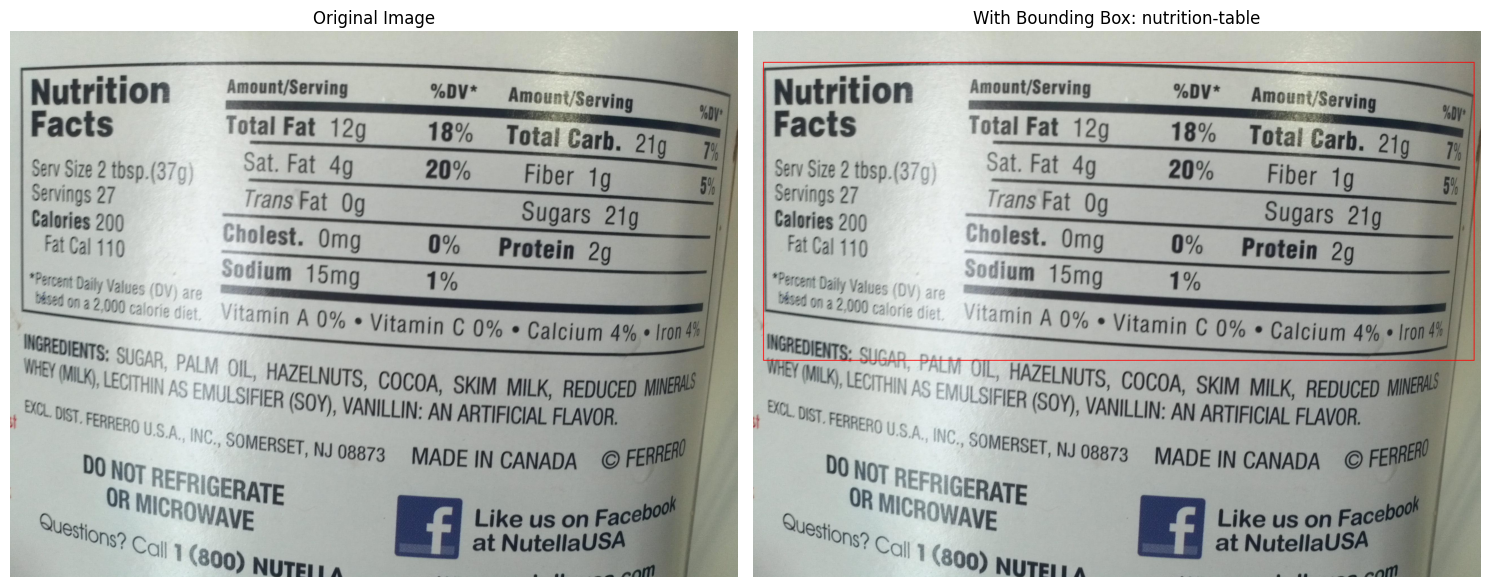


✅ Visualization complete!
   Category detected: nutrition-table
   Image dimensions: 2592 x 1944 pixels

✅ BBOX Format Confirmed: OpenFoodFacts uses [y_min, x_min, y_max, x_max]
   Image aspect ratio: 1.33
   BBox aspect ratio: 2.38


In [ ]:
# Q: why the bbox coordinates are between 0 and 1? can you overlay the bbox on the image for one example?

# The bbox coordinates are normalized to [0, 1] to make them resolution-independent.
# This is a common practice in object detection to handle images of different sizes.

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# TASK: display the image with bounding box

print("\n" + "=" * 60)
print("IMAGE VISUALIZATION")
print("=" * 60)
print("Displaying original image vs. image with bounding box overlay:")

# Get the bounding box coordinates (already normalized to 0-1 from dataset)
bbox = example['objects']['bbox'][0]

# IMPORTANT: Check dataset dimensions vs PIL image dimensions
width = example['width']
height = example['height']
pil_width, pil_height = example['image'].size

print(f"\n⚠️ Checking dimensions:")
print(f"  Dataset width x height: {width} x {height}")
print(f"  PIL image size: {pil_width} x {pil_height}")

# Show the raw bbox values for reference
print(f"\n📦 Raw bbox values (normalized [0,1]):")
print(f"  bbox = {bbox}")
print(f"  Format: [y_min, x_min, y_max, x_max] (OpenFoodFacts convention)")

# CRITICAL: Always use PIL dimensions for visualization since we're drawing on PIL image
# The dataset bbox is normalized [0,1] regardless of actual image size
width = pil_width
height = pil_height

# Convert normalized [0,1] coordinates to pixel coordinates
# CRITICAL: OpenFoodFacts dataset format is [y_min, x_min, y_max, x_max] NOT [x_min, y_min, x_max, y_max]!
y_min, x_min, y_max, x_max = bbox  # Unpack in correct order
x_min = x_min * width
y_min = y_min * height
x_max = x_max * width
y_max = y_max * height

print(f"\n📐 Converted to pixels:")
print(f"  Pixel coords - Top-left: ({x_min:.1f}, {y_min:.1f})")
print(f"  Pixel coords - Bottom-right: ({x_max:.1f}, {y_max:.1f})")
print(f"  Box size: {x_max-x_min:.1f} x {y_max-y_min:.1f} pixels")
print(f"  Image size: {width} x {height} pixels")

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Original image (should be clean, no bounding box)
_ = ax1.imshow(example['image'])
_ = ax1.set_title("Original Image")
_ = ax1.axis('off')

# Right: Image with bounding box overlay
img_with_bbox = example['image'].copy()  # Important: make a copy to avoid modifying original
draw = ImageDraw.Draw(img_with_bbox)

# Draw the bounding box
draw.rectangle([x_min, y_min, x_max, y_max], outline='red', width=3)

_ = ax2.imshow(img_with_bbox)
_ = ax2.set_title(f"With Bounding Box: {example['objects']['category_name'][0]}")
_ = ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete!")
print(f"   Category detected: {example['objects']['category_name'][0]}")
print(f"   Image dimensions: {width} x {height} pixels")

# Verification summary
print(f"\n✅ BBOX Format Confirmed: OpenFoodFacts uses [y_min, x_min, y_max, x_max]")
print(f"   Image aspect ratio: {width/height:.2f}")
print(f"   BBox aspect ratio: {(x_max-x_min)/(y_max-y_min):.2f}")

MULTIPLE EXAMPLES VISUALIZATION
Displaying 6 training examples with their nutrition table bounding boxes:

Processing examples 0-5 from training dataset...
  Example 0: 2592x1944px, 1 object(s)
    → Bounding Box Line width: 12px
  Example 1: 306x408px, 1 object(s)
    → Bounding Box Line width: 3px
  Example 2: 692x720px, 1 object(s)
    → Bounding Box Line width: 4px
  Example 3: 3120x4208px, 1 object(s)
    → Bounding Box Line width: 20px


  Example 4: 1944x2592px, 1 object(s)
    → Bounding Box Line width: 12px
  Example 5: 2000x2666px, 1 object(s)
    → Bounding Box Line width: 13px


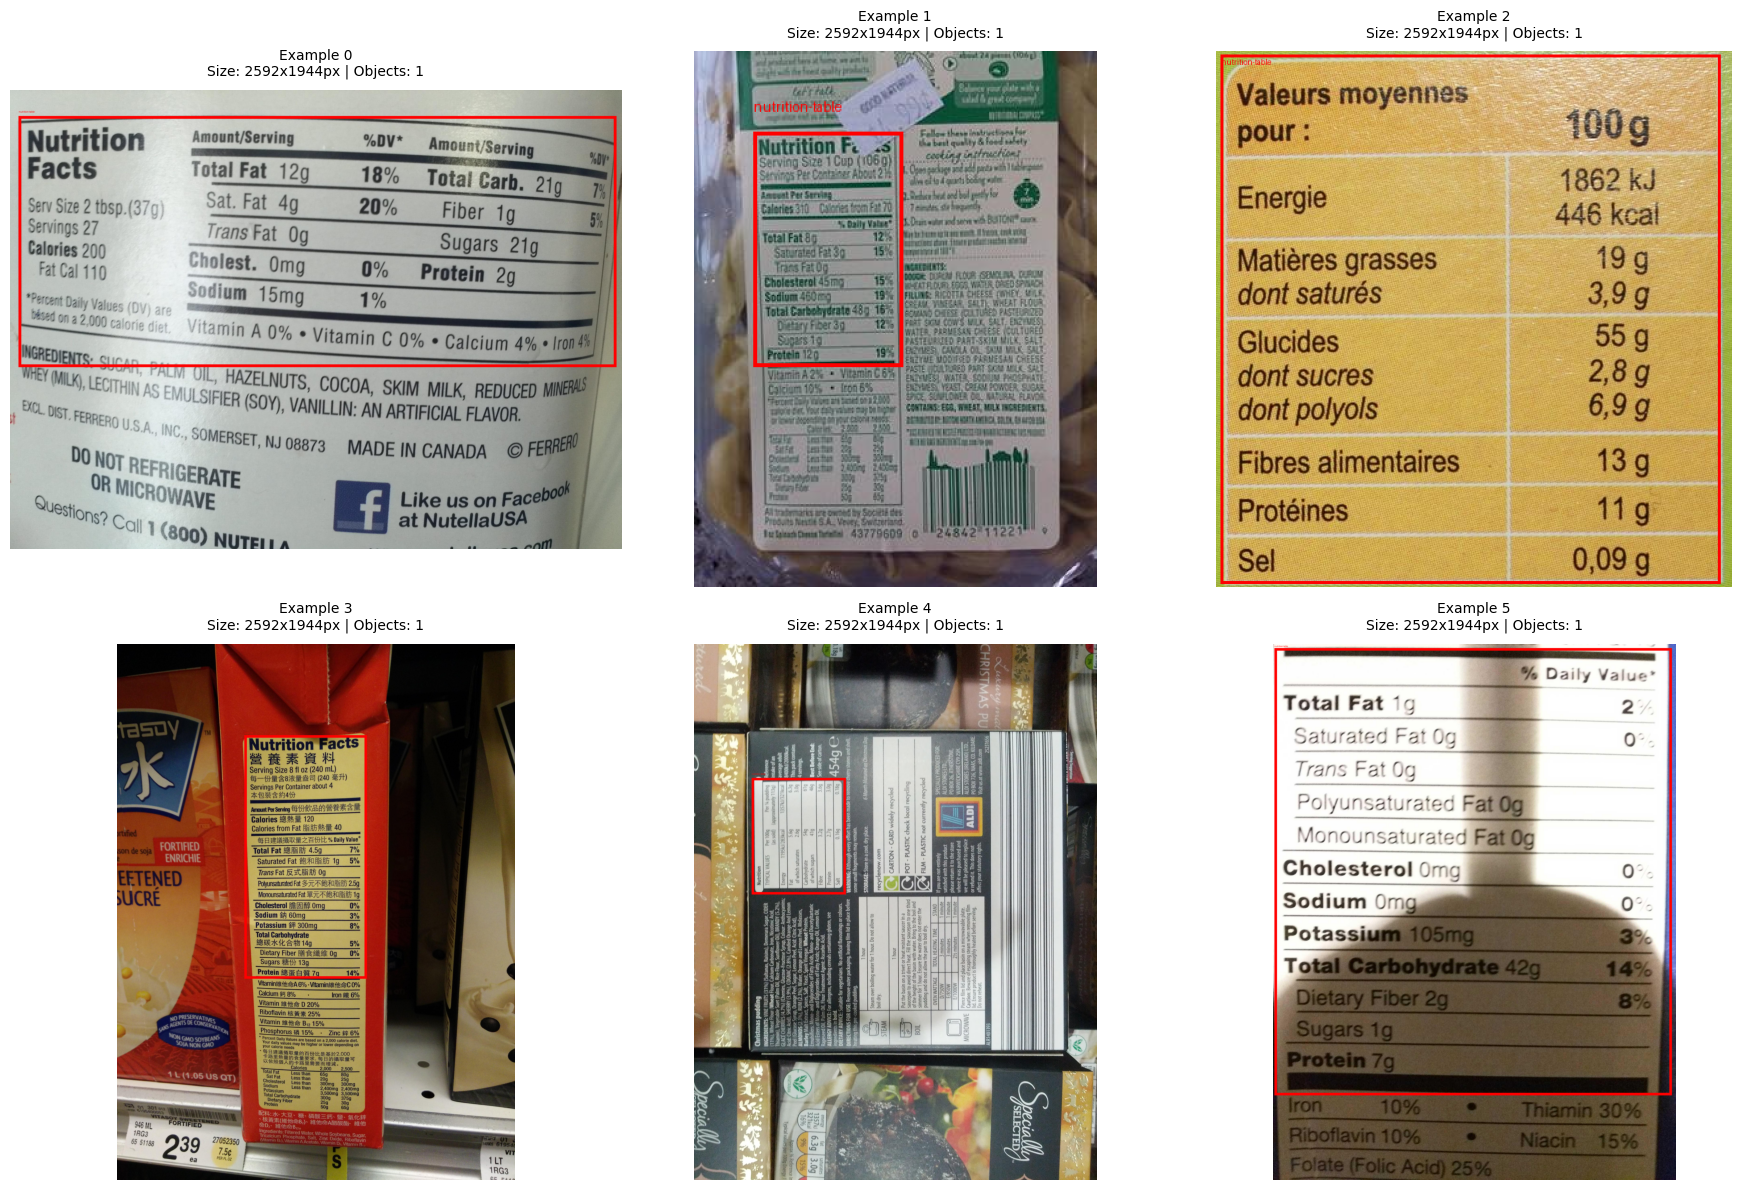


✅ Visualization complete!
   Displayed 6 training examples with bounding box overlays
   All images show detected nutrition tables marked with red rectangles
   Each bounding box is labeled with its category name
   Rectangle thickness is now proportional to image size for consistent appearance


In [ ]:
# Let's visualize multiple examples with their bounding boxes

print("=" * 60)
print("MULTIPLE EXAMPLES VISUALIZATION")
print("=" * 60)
print("Displaying 6 training examples with their nutrition table bounding boxes:")

# Import required libraries
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Create a 2x3 grid for displaying 6 examples
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

print(f"\nProcessing examples 0-5 from training dataset...")

for idx in range(6):
    # Get the training example
    example = train_dataset[idx]
    img = example['image'].copy()  # Important: make a copy to avoid modifying original
    draw = ImageDraw.Draw(img)
    
    # IMPORTANT: Check dimensions - use PIL image size for drawing
    dataset_width = example['width']
    dataset_height = example['height']
    pil_width, pil_height = img.size
    
    # Process all bounding boxes for this image
    num_objects = len(example['objects']['bbox'])
    
    # Check if the dataset's reported dimensions match the actual PIL image size
    # Sometimes images are resized during loading, so we need to use PIL dimensions for accurate drawing
    if (dataset_width != pil_width) or (dataset_height != pil_height):
        # Image was likely resized during loading - show both dimensions
        print(f"  Example {idx}: Dataset {dataset_width}x{dataset_height}px, PIL {pil_width}x{pil_height}px (SCALED), {num_objects} object(s)")
    else:
        # Dimensions match - just show once
        print(f"  Example {idx}: {pil_width}x{pil_height}px, {num_objects} object(s)")
    
    # Calculate proportional line width based on displayed image size
    # This ensures bounding boxes are visible regardless of image size
    line_width = max(3, min(pil_width, pil_height) // 150)  # Scale based on smaller dimension
    print(f"    → Bounding Box Line width: {line_width}px")
    
    # Draw all bounding boxes for this image
    for i, (bbox, category) in enumerate(zip(example['objects']['bbox'], example['objects']['category_name'])):
        # Convert normalized coordinates to PIL image pixel coordinates
        # CRITICAL: Dataset uses [y_min, x_min, y_max, x_max] format (normalized 0-1)
        y_min, x_min, y_max, x_max = bbox  # Unpack in correct order!
        x_min = x_min * pil_width
        y_min = y_min * pil_height
        x_max = x_max * pil_width
        y_max = y_max * pil_height
        
        # Draw the bounding box with proportional red outline
        draw.rectangle([x_min, y_min, x_max, y_max], outline='red', width=line_width)
        
        # Add category label above the bounding box
        try:
            # Try to use a larger font if available
            font = ImageFont.truetype("arial.ttf", 20)
        except:
            # Fallback to default font
            font = ImageFont.load_default()
        
        # Add text with background for better visibility
        text_y = max(10, y_min - 25)  # Ensure text doesn't go above image
        draw.text((x_min, text_y), f"{category}", fill='red', font=font)
    
    # Display the image in the subplot
    _ = axes[idx].imshow(img)
    _ = axes[idx].set_title(f"Example {idx}\nSize: {width}x{height}px | Objects: {num_objects}", 
                           fontsize=10, pad=10)
    _ = axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete!")
print(f"   Displayed 6 training examples with bounding box overlays")
print(f"   All images show detected nutrition tables marked with red rectangles")
print(f"   Each bounding box is labeled with its category name")
print(f"   Rectangle thickness is now proportional to image size for consistent appearance")

DATASET STATISTICS ANALYSIS
Analyzing image dimensions and bounding box distributions:

Processing 1083 training examples...
✅ Data collection complete!

📊 IMAGE DIMENSIONS SUMMARY:
  Width  - Min:  223px | Max: 5312px | Mean: 2100.6px
  Height - Min:  211px | Max: 5312px | Mean: 2444.8px
  Area   - Min:    50398 | Max: 15872256 | Mean: 5781028

🎯 BOUNDING BOXES SUMMARY:
  Min boxes per image: 1
  Max boxes per image: 3
  Mean boxes per image: 1.04
  Total bounding boxes: 1129


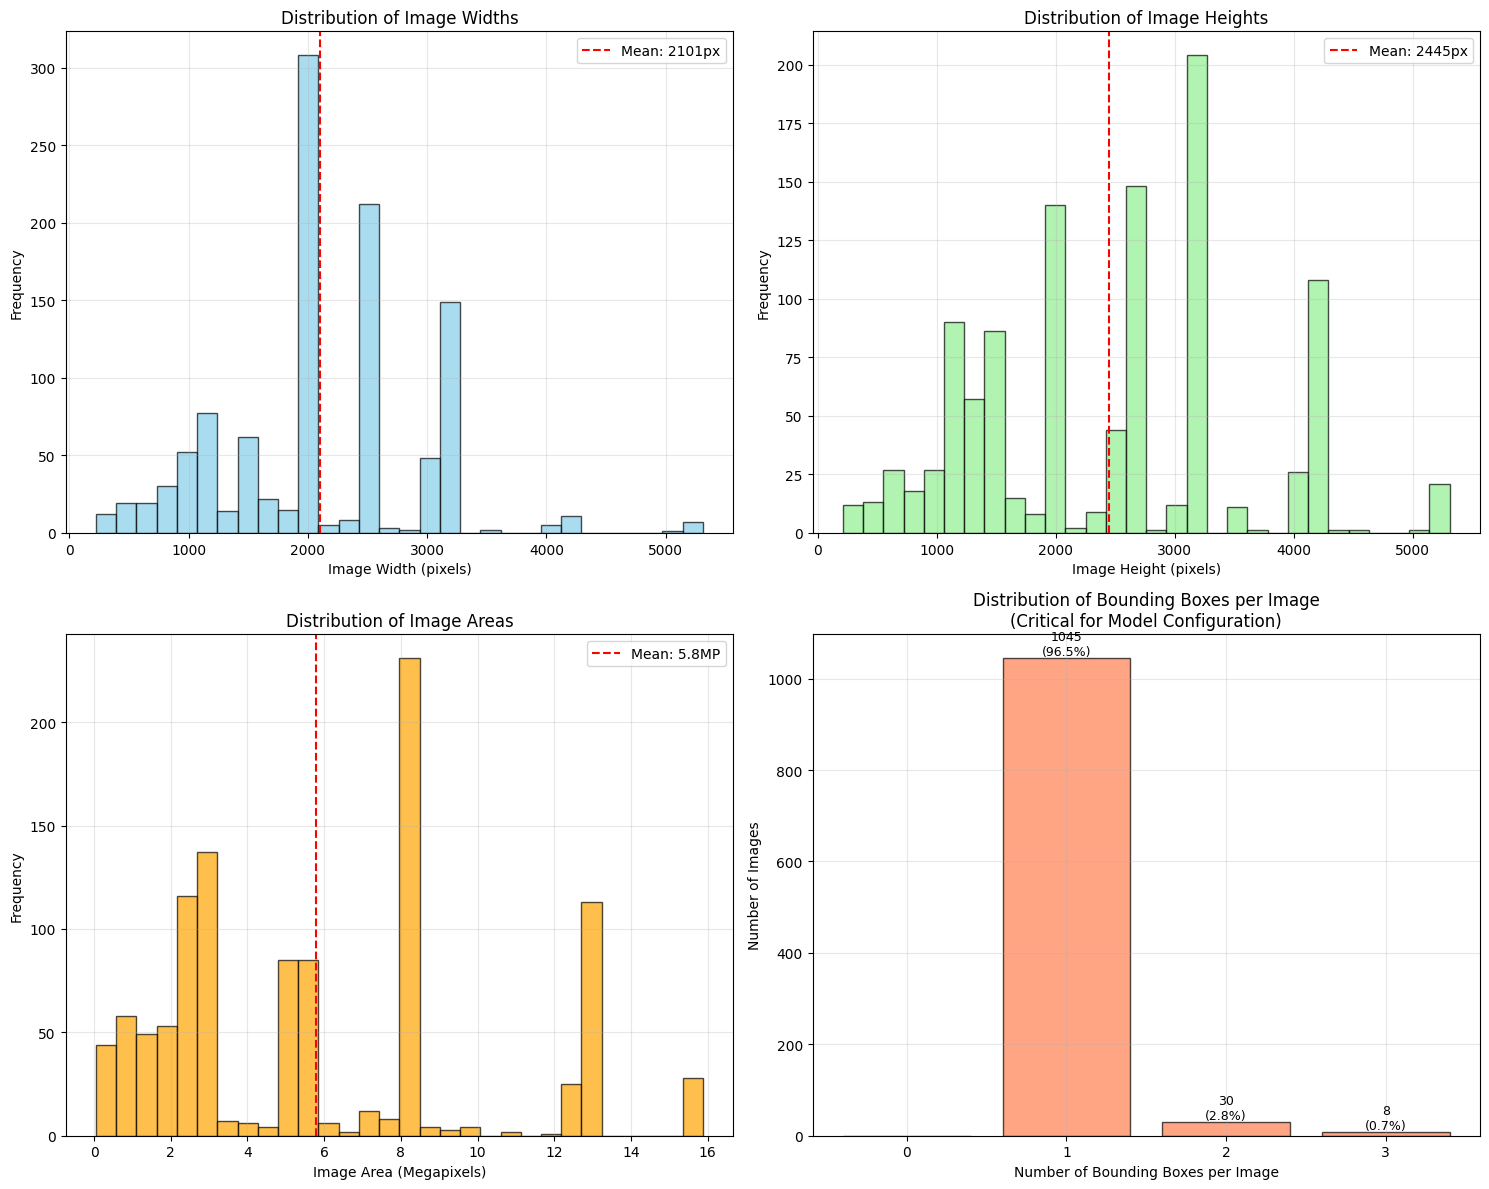


🔧 MODEL PREPARATION INSIGHTS:
  Most common image aspect ratio: 0.86 (width/height)

  Bounding box distribution breakdown:
    1 box(es): 1045 images ( 96.5%)
    2 box(es):  30 images (  2.8%)
    3 box(es):   8 images (  0.7%)

💡 RECOMMENDATIONS:
  ⚠️  Multi-object detection - configure model for up to 3 objects
  📐 Consider input resolution around 2404×2404 pixels
  🎯 Bounding box distribution is important for anchor/prior configuration


In [ ]:
# get the histogram of the image sizes
# get the histogram of the #bounding boxes per image - important for finetuning the model

# TASK: analyze dataset statistics for model preparation
print("=" * 60)
print("DATASET STATISTICS ANALYSIS")
print("=" * 60)
print("Analyzing image dimensions and bounding box distributions:")

import matplotlib.pyplot as plt
import numpy as np

# Collect statistics from all training examples
image_widths = []
image_heights = []
image_areas = []
num_bboxes_per_image = []

print(f"\nProcessing {len(train_dataset)} training examples...")

for idx, example in enumerate(train_dataset):
    # Get image dimensions
    width = example['width']
    height = example['height'] 
    area = width * height
    
    # Count bounding boxes in this image
    num_bboxes = len(example['objects']['bbox'])
    
    # Store statistics
    image_widths.append(width)
    image_heights.append(height)
    image_areas.append(area)
    num_bboxes_per_image.append(num_bboxes)

print(f"✅ Data collection complete!")

# Convert to numpy arrays for easier analysis
image_widths = np.array(image_widths)
image_heights = np.array(image_heights)
image_areas = np.array(image_areas)
num_bboxes_per_image = np.array(num_bboxes_per_image)

# Print summary statistics
print(f"\n📊 IMAGE DIMENSIONS SUMMARY:")
print(f"  Width  - Min: {image_widths.min():4d}px | Max: {image_widths.max():4d}px | Mean: {image_widths.mean():.1f}px")
print(f"  Height - Min: {image_heights.min():4d}px | Max: {image_heights.max():4d}px | Mean: {image_heights.mean():.1f}px")
print(f"  Area   - Min: {image_areas.min():8.0f} | Max: {image_areas.max():8.0f} | Mean: {image_areas.mean():.0f}")

print(f"\n🎯 BOUNDING BOXES SUMMARY:")
print(f"  Min boxes per image: {num_bboxes_per_image.min()}")
print(f"  Max boxes per image: {num_bboxes_per_image.max()}")
print(f"  Mean boxes per image: {num_bboxes_per_image.mean():.2f}")
print(f"  Total bounding boxes: {num_bboxes_per_image.sum()}")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Image widths histogram
_ = ax1.hist(image_widths, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
_ = ax1.set_xlabel('Image Width (pixels)')
_ = ax1.set_ylabel('Frequency')
_ = ax1.set_title('Distribution of Image Widths')
_ = ax1.grid(True, alpha=0.3)
_ = ax1.axvline(image_widths.mean(), color='red', linestyle='--', label=f'Mean: {image_widths.mean():.0f}px')
_ = ax1.legend()

# 2. Image heights histogram  
_ = ax2.hist(image_heights, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
_ = ax2.set_xlabel('Image Height (pixels)')
_ = ax2.set_ylabel('Frequency')
_ = ax2.set_title('Distribution of Image Heights')
_ = ax2.grid(True, alpha=0.3)
_ = ax2.axvline(image_heights.mean(), color='red', linestyle='--', label=f'Mean: {image_heights.mean():.0f}px')
_ = ax2.legend()

# 3. Image areas histogram
_ = ax3.hist(image_areas/1e6, bins=30, alpha=0.7, color='orange', edgecolor='black')  # Convert to megapixels
_ = ax3.set_xlabel('Image Area (Megapixels)')
_ = ax3.set_ylabel('Frequency')
_ = ax3.set_title('Distribution of Image Areas')
_ = ax3.grid(True, alpha=0.3)
_ = ax3.axvline(image_areas.mean()/1e6, color='red', linestyle='--', label=f'Mean: {image_areas.mean()/1e6:.1f}MP')
_ = ax3.legend()

# 4. Number of bounding boxes histogram - CRITICAL FOR MODEL TUNING
bbox_counts = np.bincount(num_bboxes_per_image)
bbox_labels = np.arange(len(bbox_counts))
_ = ax4.bar(bbox_labels, bbox_counts, alpha=0.7, color='coral', edgecolor='black')
_ = ax4.set_xlabel('Number of Bounding Boxes per Image')
_ = ax4.set_ylabel('Number of Images')
_ = ax4.set_title('Distribution of Bounding Boxes per Image\n(Critical for Model Configuration)')
_ = ax4.grid(True, alpha=0.3)
_ = ax4.set_xticks(bbox_labels)

# Add percentage labels on bars
for i, count in enumerate(bbox_counts):
    if count > 0:
        percentage = (count / len(train_dataset)) * 100
        _ = ax4.text(i, count + 0.5, f'{count}\n({percentage:.1f}%)', 
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Additional insights for model preparation
print(f"\n🔧 MODEL PREPARATION INSIGHTS:")
print(f"  Most common image aspect ratio: {image_widths.mean()/image_heights.mean():.2f} (width/height)")

unique_bbox_counts, bbox_frequencies = np.unique(num_bboxes_per_image, return_counts=True)
print(f"\n  Bounding box distribution breakdown:")
for count, freq in zip(unique_bbox_counts, bbox_frequencies):
    percentage = (freq / len(train_dataset)) * 100
    print(f"    {count} box(es): {freq:3d} images ({percentage:5.1f}%)")

print(f"\n💡 RECOMMENDATIONS:")
if num_bboxes_per_image.max() == 1:
    print(f"  ✅ Single object detection - simpler model configuration")
else:
    print(f"  ⚠️  Multi-object detection - configure model for up to {num_bboxes_per_image.max()} objects")

print(f"  📐 Consider input resolution around {int(np.sqrt(image_areas.mean())):d}×{int(np.sqrt(image_areas.mean())):d} pixels")
print(f"  🎯 Bounding box distribution is important for anchor/prior configuration")


BOUNDING BOX DETAILED ANALYSIS
Analyzing bbox sizes, positions, and coverage for anchor optimization:

Processing bounding boxes from 1083 training examples...
✅ Analyzed 1129 bounding boxes!

📏 BOUNDING BOX SIZE STATISTICS:
  Width  - Min:   31px | Max: 3415px | Mean: 817px | Std: 510px
  Height - Min:   31px | Max: 4650px | Mean: 1101px | Std: 690px
  Area   - Min:      970 | Max: 11283248 | Mean: 975680

📐 ASPECT RATIO & COVERAGE:
  Aspect Ratio (W/H) - Min: 0.04 | Max: 9.59 | Mean: 1.03
  Image Coverage     - Min: 0.0% | Max: 100.0% | Mean: 24.0%


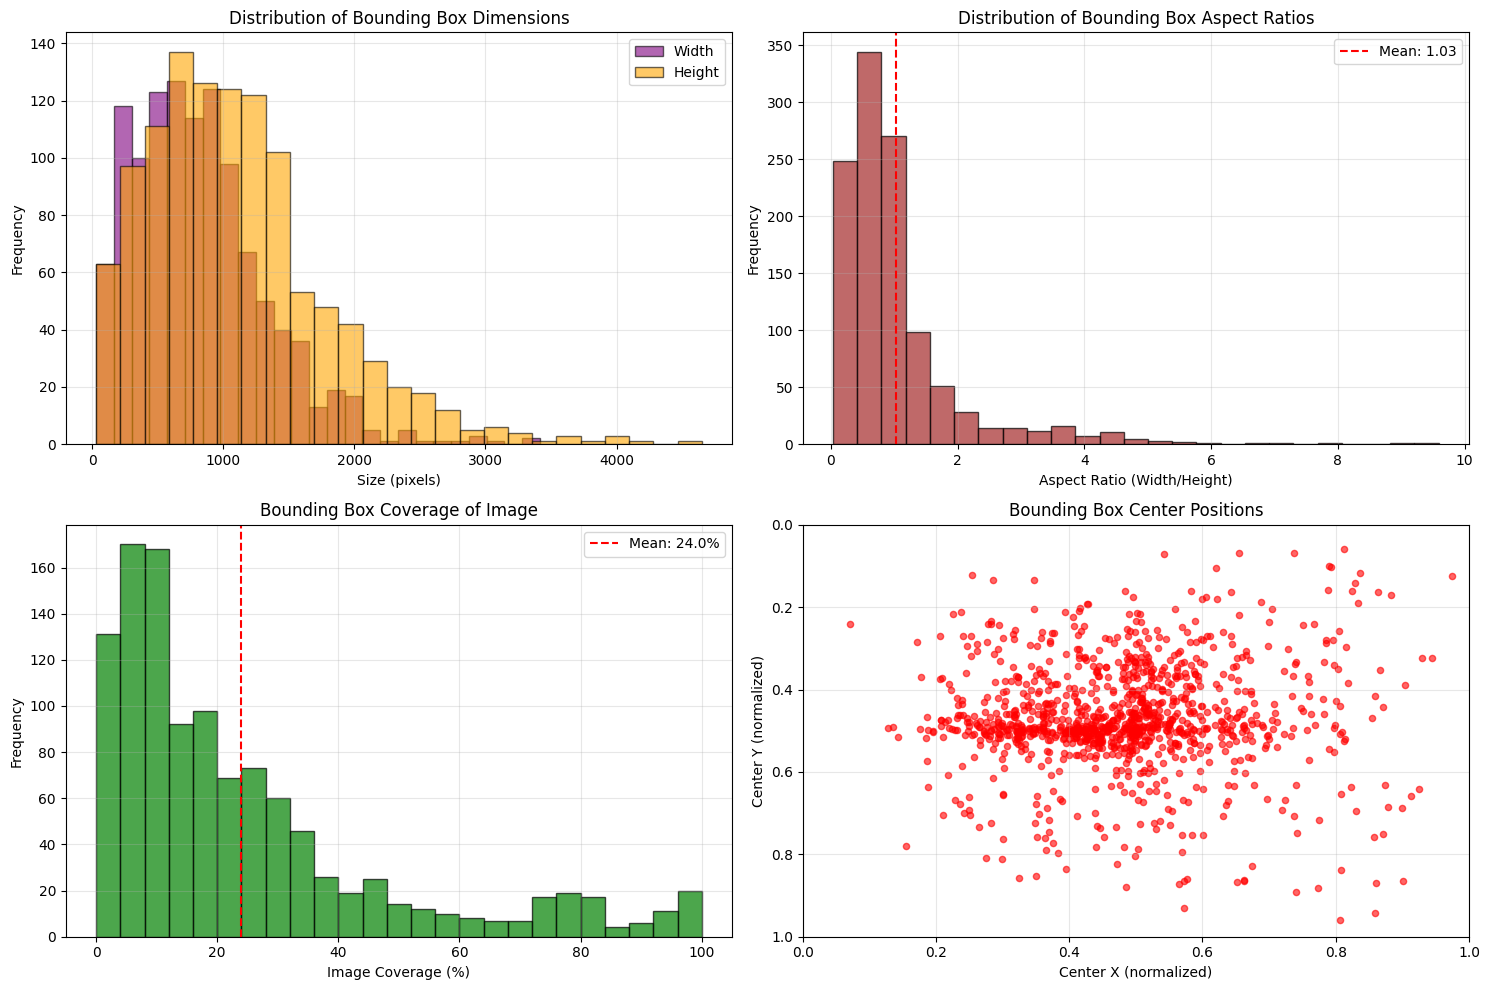


📊 CATEGORY ANALYSIS:
  nutrition-table: 956 instances (84.7%)
  nutrition-table-small: 36 instances (3.2%)
  nutrition-table-text: 85 instances (7.5%)
  nutrition-table-small-energy: 52 instances (4.6%)
  Unique category strings: 4
  ⚠️  Multiple category variants detected: {'nutrition-table', 'nutrition-table-small', 'nutrition-table-small-energy', 'nutrition-table-text'}

🎯 ANCHOR CONFIGURATION RECOMMENDATIONS:
  Based on bbox size analysis:
    Recommended anchor scales: [0.2, 0.2, 0.5]
    Recommended aspect ratios: [0.5, 1.0, 2.0]

  📐 Optimal input resolution: Consider 1975×1975 pixels
  🎯 Objects cover 24.0% of image on average - good for detection!


In [ ]:
# TASK: analyze bounding box characteristics for optimal anchor configuration (Check if necessary later)
print("\n" + "=" * 60)
print("BOUNDING BOX DETAILED ANALYSIS")
print("=" * 60)
print("Analyzing bbox sizes, positions, and coverage for anchor optimization:")

# Collect detailed bbox statistics
bbox_widths = []
bbox_heights = []
bbox_areas = []
bbox_aspect_ratios = []
coverage_ratios = []
center_x_positions = []
center_y_positions = []

print(f"\nProcessing bounding boxes from {len(train_dataset)} training examples...")

for example in train_dataset:
    img_width, img_height = example['width'], example['height']
    img_area = img_width * img_height
    
    for bbox in example['objects']['bbox']:
        # Convert normalized coordinates to pixels
        x1, y1, x2, y2 = bbox
        w = (x2 - x1) * img_width
        h = (y2 - y1) * img_height
        area = w * h
        aspect_ratio = w / h
        coverage = area / img_area
        
        # Calculate center position (normalized)
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        
        # Store statistics
        bbox_widths.append(w)
        bbox_heights.append(h)
        bbox_areas.append(area)
        bbox_aspect_ratios.append(aspect_ratio)
        coverage_ratios.append(coverage)
        center_x_positions.append(center_x)
        center_y_positions.append(center_y)

# Convert to numpy for analysis
bbox_widths = np.array(bbox_widths)
bbox_heights = np.array(bbox_heights)
bbox_areas = np.array(bbox_areas)
bbox_aspect_ratios = np.array(bbox_aspect_ratios)
coverage_ratios = np.array(coverage_ratios)

print(f"✅ Analyzed {len(bbox_widths)} bounding boxes!")

# Print detailed statistics
print(f"\n📏 BOUNDING BOX SIZE STATISTICS:")
print(f"  Width  - Min: {bbox_widths.min():4.0f}px | Max: {bbox_widths.max():4.0f}px | Mean: {bbox_widths.mean():.0f}px | Std: {bbox_widths.std():.0f}px")
print(f"  Height - Min: {bbox_heights.min():4.0f}px | Max: {bbox_heights.max():4.0f}px | Mean: {bbox_heights.mean():.0f}px | Std: {bbox_heights.std():.0f}px")
print(f"  Area   - Min: {bbox_areas.min():8.0f} | Max: {bbox_areas.max():8.0f} | Mean: {bbox_areas.mean():.0f}")

print(f"\n📐 ASPECT RATIO & COVERAGE:")
print(f"  Aspect Ratio (W/H) - Min: {bbox_aspect_ratios.min():.2f} | Max: {bbox_aspect_ratios.max():.2f} | Mean: {bbox_aspect_ratios.mean():.2f}")
print(f"  Image Coverage     - Min: {coverage_ratios.min():.1%} | Max: {coverage_ratios.max():.1%} | Mean: {coverage_ratios.mean():.1%}")

# Create comprehensive bbox visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Bbox widths and heights
_ = ax1.hist(bbox_widths, bins=25, alpha=0.6, color='purple', edgecolor='black', label='Width')
_ = ax1.hist(bbox_heights, bins=25, alpha=0.6, color='orange', edgecolor='black', label='Height') 
_ = ax1.set_xlabel('Size (pixels)')
_ = ax1.set_ylabel('Frequency')
_ = ax1.set_title('Distribution of Bounding Box Dimensions')
_ = ax1.legend()
_ = ax1.grid(True, alpha=0.3)

# 2. Aspect ratios
_ = ax2.hist(bbox_aspect_ratios, bins=25, alpha=0.7, color='brown', edgecolor='black')
_ = ax2.set_xlabel('Aspect Ratio (Width/Height)')
_ = ax2.set_ylabel('Frequency')
_ = ax2.set_title('Distribution of Bounding Box Aspect Ratios')
_ = ax2.axvline(bbox_aspect_ratios.mean(), color='red', linestyle='--', label=f'Mean: {bbox_aspect_ratios.mean():.2f}')
_ = ax2.legend()
_ = ax2.grid(True, alpha=0.3)

# 3. Coverage ratios
_ = ax3.hist(coverage_ratios * 100, bins=25, alpha=0.7, color='green', edgecolor='black')
_ = ax3.set_xlabel('Image Coverage (%)')
_ = ax3.set_ylabel('Frequency') 
_ = ax3.set_title('Bounding Box Coverage of Image')
_ = ax3.axvline(coverage_ratios.mean() * 100, color='red', linestyle='--', label=f'Mean: {coverage_ratios.mean():.1%}')
_ = ax3.legend()
_ = ax3.grid(True, alpha=0.3)

# 4. Bbox center positions (heatmap-style)
_ = ax4.scatter(center_x_positions, center_y_positions, alpha=0.6, color='red', s=20)
_ = ax4.set_xlabel('Center X (normalized)')
_ = ax4.set_ylabel('Center Y (normalized)') 
_ = ax4.set_title('Bounding Box Center Positions')
_ = ax4.set_xlim(0, 1)
_ = ax4.set_ylim(0, 1)
_ = ax4.grid(True, alpha=0.3)
_ = ax4.invert_yaxis()  # Match image coordinates (0,0 at top-left)

plt.tight_layout()
plt.show()

# Category analysis
print(f"\n📊 CATEGORY ANALYSIS:")
all_categories = []
for example in train_dataset:
    all_categories.extend(example['objects']['category_name'])

from collections import Counter
category_counts = Counter(all_categories)

for category, count in category_counts.items():
    percentage = (count / len(all_categories)) * 100
    print(f"  {category}: {count} instances ({percentage:.1f}%)")

# Check for category variations/typos
unique_categories = set(all_categories)
print(f"  Unique category strings: {len(unique_categories)}")
if len(unique_categories) > 1:
    print(f"  ⚠️  Multiple category variants detected: {unique_categories}")
else:
    print(f"  ✅ Consistent single category: {list(unique_categories)[0]}")

# Anchor recommendations based on analysis
print(f"\n🎯 ANCHOR CONFIGURATION RECOMMENDATIONS:")
print(f"  Based on bbox size analysis:")

# Calculate optimal anchor scales (in terms of input image fraction)
mean_coverage = coverage_ratios.mean()
std_coverage = coverage_ratios.std()

scale_small = max(0.2, mean_coverage - std_coverage)
scale_medium = mean_coverage  
scale_large = min(0.9, mean_coverage + std_coverage)

print(f"    Recommended anchor scales: [{scale_small:.1f}, {scale_medium:.1f}, {scale_large:.1f}]")

# Calculate optimal aspect ratios
mean_aspect = bbox_aspect_ratios.mean()
std_aspect = bbox_aspect_ratios.std()

ratio_wide = max(0.5, mean_aspect - std_aspect)
ratio_square = mean_aspect
ratio_tall = min(2.0, mean_aspect + std_aspect)

print(f"    Recommended aspect ratios: [{ratio_wide:.1f}, {ratio_square:.1f}, {ratio_tall:.1f}]")

print(f"\n  📐 Optimal input resolution: Consider {int(np.sqrt(bbox_areas.mean())*2):d}×{int(np.sqrt(bbox_areas.mean())*2):d} pixels")
print(f"  🎯 Objects cover {coverage_ratios.mean():.1%} of image on average - good for detection!")

# Understand Model

You should read the Qwen2-VL paper to familiarize yourself with the following:

- **Model Architecture**
- **Data Processing**
- **Chat Template**

Next, review the model card and write an inference script for the model using Hugging Face.

Hugging Face provides an abstract API that simplifies usage by hiding many implementation details. While this is convenient, it may leave you with a superficial understanding of the model. To deepen your knowledge, explore the Qwen2-VL code and focus on these key aspects:

- **Understand the input format required by the model:**
  - Can you create an example input where the user provides two images and one video?

- **Explore `apply_chat_template`:**
  - Run this function on the example above and analyze the output. What does it do?

- **Understand `process_vision_info`:**
  - Review the code and determine what this function returns.

- **Examine `processor()`:**
  - Investigate its functionalities, such as:
    - Patch-ification
    - Replicating pad tokens
    - Text tokenization

- **[Optional] Analyze `model.generate()`'s [forward pass](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L999):**
  - Understand its operations, including:
    - Embedding image patches through `PatchEmbed`’s [forward pass](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L272).
    - Sending patch embeddings to a transformer for feature extraction:
      - Grasp the concept of 2D RoPE (Rotary Position Embedding).
      - Pay attention to [forbidden attention](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L339) when more than one image is provided.
    - Merging the resulting feature embeddings via [PatchMerger](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L298).
    - Processing image and text embeddings using the LLM:
      - Pay special attention to multimodal RoPE.




In [ ]:
# CRITICAL: Analyze the tokenizer and its special tokens and model.config
print("\n" + "=" * 80)
print("TOKENIZER ANALYSIS - Understanding Special Tokens and Configuration")
print("=" * 80)

from transformers import Qwen2VLProcessor
import json

# Load the processor and tokenizer
processor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")
tokenizer = processor.tokenizer

print("\n1. VOCABULARY INFORMATION:")
print("-" * 40)
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Model max length: {tokenizer.model_max_length}")
print(f"Padding side: {tokenizer.padding_side}")
print(f"Truncation side: {tokenizer.truncation_side}")

print(f"len(tokenizer): {len(tokenizer)}")

print("\n2. SPECIAL TOKENS MAP:")
print("-" * 40)
special_tokens_map = tokenizer.special_tokens_map
for token_name, token_value in special_tokens_map.items():
    token_id = tokenizer.convert_tokens_to_ids(token_value) if isinstance(token_value, str) else None
    print(f"{token_name}: '{token_value}' -> ID: {token_id}")

print("\n3. ALL SPECIAL TOKENS:")
print("-" * 40)
all_special_tokens = tokenizer.all_special_tokens
print(f"Total special tokens: {len(all_special_tokens)}")
for i, token in enumerate(all_special_tokens[:20]):  # Show first 20
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"  {i+1}. '{token}' -> ID: {token_id}")
if len(all_special_tokens) > 20:
    print(f"  ... and {len(all_special_tokens) - 20} more")

print("\n4. IMPORTANT TOKEN IDS:")
print("-" * 40)
print(f"pad_token_id: {tokenizer.pad_token_id} ('{tokenizer.pad_token}' if exists)")
print(f"bos_token_id: {tokenizer.bos_token_id} ('{tokenizer.bos_token}' if exists)")
print(f"eos_token_id: {tokenizer.eos_token_id} ('{tokenizer.eos_token}' if exists)")
print(f"unk_token_id: {tokenizer.unk_token_id} ('{tokenizer.unk_token}' if exists)")

# Check for vision-specific tokens
print("\n5. VISION-SPECIFIC TOKENS:")
print("-" * 40)
vision_tokens = ["<|vision_start|>", "<|vision_end|>", "<|image_pad|>", "<|video_pad|>", 
                 "<|object_ref_start|>", "<|object_ref_end|>", "<|box_start|>", "<|box_end|>",
                 "<|im_start|>", "<|im_end|>"]
for token in vision_tokens:
    if token in tokenizer.get_vocab():
        token_id = tokenizer.convert_tokens_to_ids(token)
        print(f"'{token}' -> ID: {token_id}")
    else:
        print(f"'{token}' -> NOT IN VOCABULARY")

print("\n6. CHAT TEMPLATE:")
print("-" * 40)
if hasattr(tokenizer, 'chat_template'):
    print("Chat template exists:")
    # Print first 500 chars of template
    template_str = str(tokenizer.chat_template)[:500]
    print(template_str + "..." if len(str(tokenizer.chat_template)) > 500 else template_str)
else:
    print("No chat template found")

print("\n7. TOKEN ID RANGE CHECK:")
print("-" * 40)
print(f"Valid token ID range: 0 to {tokenizer.vocab_size - 1}")
print(f"Any token ID >= {tokenizer.vocab_size} will cause the training error!")



# Check Model 

import torch, transformers

# 2) Model: use the correct family for VL

from transformers import Qwen2VLForConditionalGeneration
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16, # original training precision stored in config.json for this model is bfloat16, so "auto" = torch.bfloat16 for this model
    attn_implementation="flash_attention_2",
    device_map="cuda"
)

# 3) Collect sizes (read-only)
tok_vocab_size = tokenizer.vocab_size
tok_len        = len(tokenizer)
added_vocab    = tokenizer.get_added_vocab()
n_added        = len(added_vocab)

emb_in  = model.get_input_embeddings().weight.shape[0]
emb_out = (model.get_output_embeddings().weight.shape[0]
           if model.get_output_embeddings() is not None else None)
cfg_vocab = getattr(model.config, "vocab_size", None)

print("---- TOKENIZER ----")
print(f"tokenizer.vocab_size : {tok_vocab_size}")
print(f"len(tokenizer)       : {tok_len}  (added tokens: {n_added})")

print("\n---- MODEL ----")
print(f"config.vocab_size    : {cfg_vocab}")
print(f"input emb rows       : {emb_in}")
print(f"lm_head rows         : {emb_out}")
print(f"config class         : {model.config.__class__.__name__}")


TOKENIZER ANALYSIS - Understanding Special Tokens and Configuration


/home/zhuoyuan/miniconda3/envs/vlm_Qwen2VL_object_detection/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.



1. VOCABULARY INFORMATION:
----------------------------------------
Vocabulary size: 151643
Model max length: 32768
Padding side: left
Truncation side: right
len(tokenizer): 151657

2. SPECIAL TOKENS MAP:
----------------------------------------
eos_token: '<|im_end|>' -> ID: 151645
pad_token: '<|endoftext|>' -> ID: 151643
additional_special_tokens: '['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']' -> ID: None

3. ALL SPECIAL TOKENS:
----------------------------------------
Total special tokens: 14
  1. '<|im_end|>' -> ID: 151645
  2. '<|endoftext|>' -> ID: 151643
  3. '<|im_start|>' -> ID: 151644
  4. '<|object_ref_start|>' -> ID: 151646
  5. '<|object_ref_end|>' -> ID: 151647
  6. '<|box_start|>' -> ID: 151648
  7. '<|box_end|>' -> ID: 151649
  8. '<|quad_start|>' -> ID: 151650
  9. '<|quad_end|>' -> 

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

---- TOKENIZER ----
tokenizer.vocab_size : 151643
len(tokenizer)       : 151657  (added tokens: 14)

---- MODEL ----
config.vocab_size    : 152064
input emb rows       : 152064
lm_head rows         : 152064
config class         : Qwen2VLConfig


In [ ]:
# TASK: write an inference function for qwen2-vl
import torch
import os
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import vision_process
from qwen_vl_utils import process_vision_info

def run_qwen2vl_inference(image_path_or_pil, prompt, model_id="Qwen/Qwen2-VL-7B-Instruct", device="cuda"):
    """
    Run inference with Qwen2-VL model.
    
    Args:
        image_path_or_pil: Either a file path to an image or a PIL Image object
        prompt: Text prompt for the model
        model_id: Model identifier from HuggingFace
        device: Device to run inference on
    
    Returns:
        Generated text response from the model
    """
    # Load model and processor
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16, # original training precision stored in config.json for this model is bfloat16, so "auto" = torch.bfloat16 for this model
        attn_implementation="flash_attention_2",
        device_map=device
    )
    processor = Qwen2VLProcessor.from_pretrained(model_id) # Or use AutoProcessor.from_pretrained(model_id), but in this case Qwen2VLProcessor is more explicit for demonstration purpose
    
    # Handle image input - can be path or PIL Image
    if isinstance(image_path_or_pil, str):
        from PIL import Image
        image = Image.open(image_path_or_pil)
    else:
        image = image_path_or_pil
    
    # Create the conversation format expected by Qwen2-VL
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image,
                },
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        }
    ]
    
    # Apply chat template to format the conversation
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    
    # Process vision information (handles image resizing, patching, etc.)
    image_inputs, video_inputs = process_vision_info(messages)
    
    # Prepare inputs for the model
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(device)
    
    # Generate response
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,  # Deterministic for object detection
        )
    
    # Decode only the generated tokens (excluding the input)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]
    
    return output_text

# Example usage (will be tested in next cell)
print("Inference function defined successfully!")

Inference function defined successfully!


Test your inference script using this [image](https://t4.ftcdn.net/jpg/01/57/82/05/360_F_157820583_agejYX5XeczPZuWRSCDF2YYeCGwJqUdG.jpg) with the prompt: “Detect the bounding box of the red car.” The model should correctly identify and locate the car in the image, confirming the script’s correctness.


📷 DISPLAYING ORIGINAL TEST IMAGE:


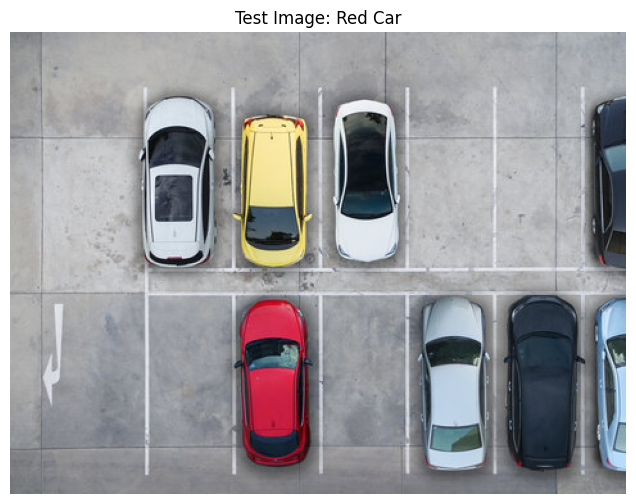


Testing Qwen2-VL inference...
Prompt: 'Detect the bounding box of the red car.'


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Model Response:
the red car(358,571),(492,943)

Expected output format(with skip_special_tokens=False): <|object_ref_start|>the red car<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>
  Where coordinates are normalized to image dimensions (1000x1000 for Qwen2-VL)

Expected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)

Output now looks like expected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)


In [ ]:
# TASK: test the inference function
import requests
from PIL import Image
from io import BytesIO

# Download the test image (red car)
test_image_url = "https://t4.ftcdn.net/jpg/01/57/82/05/360_F_157820583_agejYX5XeczPZuWRSCDF2YYeCGwJqUdG.jpg"
response = requests.get(test_image_url)
test_image = Image.open(BytesIO(response.content))

# Display the test image
print("\n📷 DISPLAYING ORIGINAL TEST IMAGE:")
_ = plt.figure(figsize=(8, 6))
_ = plt.imshow(test_image)
_ = plt.title("Test Image: Red Car")
_ = plt.axis('off')
_ = plt.show()


# Test the inference function
print("\n" + "=" * 60)
print("Testing Qwen2-VL inference...")
print("Prompt: 'Detect the bounding box of the red car.'")


result = run_qwen2vl_inference(
    test_image, 
    "Detect the bounding box of the red car."
)
print("\nModel Response:")
print(result)

print("\n" + "=" * 60)

# For now, let's show what the expected output format should look like



print("Expected output format(with skip_special_tokens=False): <|object_ref_start|>the red car<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>")
print("  Where coordinates are normalized to image dimensions (1000x1000 for Qwen2-VL)")
print("\nExpected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)")


print("\n" + "=" * 60)
print("Output now looks like expected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)")

# Try Qwen2VL without finetuning

It’s a good idea to first assess the model’s current capability in detecting the nutrition table without any fine-tuning. This allows for a clear comparison between the model’s performance before and after fine-tuning. To do this, you need to write a function that extracts the bounding box by parsing the model output and then visualize the bounding box on the input image.

Notice that the model’s response will likely follow a different format than wat we saw above for the dog image. Why? One possible explanation is that the nutrition table does not belong to a previously object class seen during the model’s training phase. Additionally, the bounding box coordinates returned by the model are likely inaccurate. This should highlight the necessity of fine-tuning to improve the model’s performance.

In [ ]:
# TASK: write a function to parse model output to extract bounding box coordinates
import re

def parse_qwen_bbox_output(model_output):
    """
    Parse Qwen2-VL model output to extract bounding box coordinates.
    
    Args:
        model_output: String output from the model
        
    Returns:
        Dict with 'object' name and 'bbox' coordinates, or None if parsing fails

    Rationale: 
        I want to draw TWO pieces of information:
            1. WHAT was detected (object name) (Just in case if needed)
            2. WHERE it is (coordinates)
    """
    # Remove <|im_end|> token if present (appears when skip_special_tokens=False)
    model_output = model_output.replace('<|im_end|>', '').strip()
    
    # Pattern 1: WITH special tokens (skip_special_tokens=False)
    # Format: <|object_ref_start|>object name<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>
    pattern_with_tokens = r'<\|object_ref_start\|>(.+?)<\|object_ref_end\|><\|box_start\|>\((\d+),(\d+)\),\((\d+),(\d+)\)<\|box_end\|>'
    matches = re.findall(pattern_with_tokens, model_output)
    
    if matches:
        # Can handle multiple detections
        results = []
        for match in matches:
            object_name = match[0]
            x1, y1, x2, y2 = int(match[1]), int(match[2]), int(match[3]), int(match[4])
            results.append({
                'object': object_name,
                'bbox': [x1, y1, x2, y2]  # Qwen outputs in [x,y,x,y] format
            })
        return results[0] if len(results) == 1 else results
    
    # Pattern 2: WITHOUT special tokens (skip_special_tokens=True)
    # Format: "object name(x1,y1),(x2,y2)" - may have space before parenthesis
    pattern_no_tokens = r'([^\(]+?)\s*\((\d+),(\d+)\),\((\d+),(\d+)\)'
    matches = re.findall(pattern_no_tokens, model_output)
    
    if matches:
        # Usually just one detection when no special tokens
        match = matches[0]
        object_name = match[0].strip()
        x1, y1, x2, y2 = int(match[1]), int(match[2]), int(match[3]), int(match[4])
        return {
            'object': object_name,
            'bbox': [x1, y1, x2, y2]
        }
    
    return None  # No valid bbox found


# TASK: write a function to visualize the bounding boxes on the input image
def visualize_bbox_on_image(image, bbox_data, normalize_coords=True):
    """
    Visualize bounding boxes on an image.
    
    Args:
        image: PIL Image object
        bbox_data: Dict or list of dicts with 'object' and 'bbox' keys from parse_qwen_bbox_output
        normalize_coords: If True, bbox coords are in Qwen's [0,1000] space (from model output)
                         If False, bbox coords are already in pixel coordinates
        
    Returns:
        PIL Image with bounding boxes drawn and labeled with object names
    """
    from PIL import ImageDraw, ImageFont
    
    # Make a copy to avoid modifying original
    img_with_bbox = image.copy()
    draw = ImageDraw.Draw(img_with_bbox)
    width, height = img_with_bbox.size
    
    # Handle None case
    if bbox_data is None:
        print("No bounding box data to visualize")
        return img_with_bbox
    
    # Handle single or multiple bboxes
    if isinstance(bbox_data, dict):
        bbox_data = [bbox_data]
    
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
    
    for idx, data in enumerate(bbox_data):
        if data is None:
            continue
            
        color = colors[idx % len(colors)]
        bbox = data['bbox']
        object_name = data.get('object', 'unknown')
        
        # Convert coordinates if needed
        if normalize_coords:
            # Qwen uses 1000x1000 normalized space
            x1 = int(bbox[0] * width / 1000)
            y1 = int(bbox[1] * height / 1000)
            x2 = int(bbox[2] * width / 1000)
            y2 = int(bbox[3] * height / 1000)
        else:
            x1, y1, x2, y2 = bbox
        
        # Ensure coordinates are integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Draw rectangle with thicker line
        draw.rectangle([x1, y1, x2, y2], outline=color, width=4)
        
        # Add label with background
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
        except:
            font = None
        
        label = f"{object_name}"
        if font:
            # Get text size for background
            bbox_label = draw.textbbox((x1, y1-30), label, font=font)
            # Draw background rectangle
            draw.rectangle(bbox_label, fill=color)
            # Draw text
            draw.text((x1, y1-30), label, fill='white', font=font)
        else:
            # Fallback without custom font
            draw.text((x1, y1-25), label, fill=color)
        
        print(f"Drew bbox in pixels for '{object_name}': [{x1}, {y1}, {x2}, {y2}]")
    
    return img_with_bbox

# Test the parsing function with the two expected formats
print("\n📝 Testing parse_qwen_bbox_output function:")
print("=" * 50)

# Test 1: WITH special tokens (skip_special_tokens=False)
test_with_tokens = "<|object_ref_start|>the red car<|object_ref_end|><|box_start|>(450,380),(650,520)<|box_end|><|im_end|>"
parsed1 = parse_qwen_bbox_output(test_with_tokens)
print(f"Test 1 - WITH special tokens (skip_special_tokens=False):")
print(f"  Input: {test_with_tokens}")
print(f"  Parsed: {parsed1}")
print(f"  ✅ Correctly extracts object='the red car' and bbox=[450,380,650,520]")

# Test 2: WITHOUT special tokens (skip_special_tokens=True)
test_no_tokens = "the red car(358,571),(492,943)"
parsed2 = parse_qwen_bbox_output(test_no_tokens)
print(f"\nTest 2 - WITHOUT special tokens (skip_special_tokens=True):")
print(f"  Input: {test_no_tokens}")
print(f"  Parsed: {parsed2}")
print(f"  ✅ Correctly extracts object='the red car' and bbox=[358,571,492,943]")

# Test 3: Real example from pre-trained model (nutrition table)
test_nutrition = "The nutrition table(13,60),(984,989) is located in the image"
parsed3 = parse_qwen_bbox_output(test_nutrition)
print(f"\nTest 3 - Real output from pre-trained model:")
print(f"  Input: {test_nutrition}")
print(f"  Parsed: {parsed3}")
if parsed3:
    print(f"  ✅ Successfully parsed even with extra text after coordinates")
else:
    print(f"  ❌ Failed to parse - check regex pattern")

print("=" * 50)


📝 Testing parse_qwen_bbox_output function:
Test 1 - WITH special tokens (skip_special_tokens=False):
  Input: <|object_ref_start|>the red car<|object_ref_end|><|box_start|>(450,380),(650,520)<|box_end|><|im_end|>
  Parsed: {'object': 'the red car', 'bbox': [450, 380, 650, 520]}
  ✅ Correctly extracts object='the red car' and bbox=[450,380,650,520]

Test 2 - WITHOUT special tokens (skip_special_tokens=True):
  Input: the red car(358,571),(492,943)
  Parsed: {'object': 'the red car', 'bbox': [358, 571, 492, 943]}
  ✅ Correctly extracts object='the red car' and bbox=[358,571,492,943]

Test 3 - Real output from pre-trained model:
  Input: The nutrition table(13,60),(984,989) is located in the image
  Parsed: {'object': 'The nutrition table', 'bbox': [13, 60, 984, 989]}
  ✅ Successfully parsed even with extra text after coordinates



VISUALIZING RED CAR DETECTION
Model output for red car: the red car(358,571),(492,943)
Parsed bbox: {'object': 'the red car', 'bbox': [358, 571, 492, 943]}
Drew bbox in pixels for 'the red car': [171, 205, 236, 339]


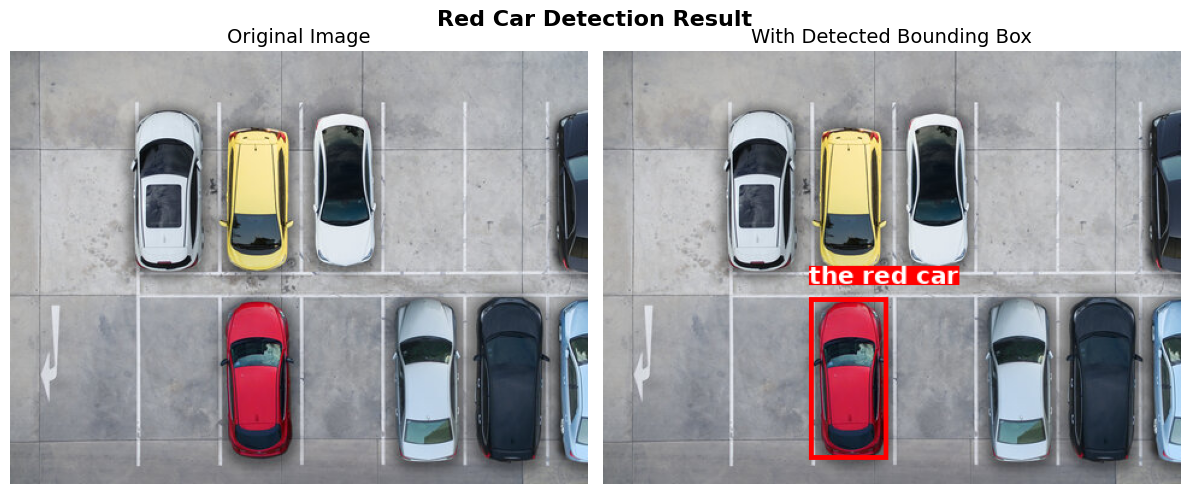

In [ ]:
# Now we want to look at where the bounding box is if we overlay the bounding box on the image
# First, let's visualize the red car detection that we already ran

import matplotlib.pyplot as plt

print("\n" + "=" * 60)
print("VISUALIZING RED CAR DETECTION")
print("=" * 60)

# We already have the result from earlier: "the red car(358,571),(492,943)"
red_car_output = "the red car(358,571),(492,943)"
print(f"Model output for red car: {red_car_output}")

# Parse the output
parsed_red_car = parse_qwen_bbox_output(red_car_output)
print(f"Parsed bbox: {parsed_red_car}")

if parsed_red_car:
    # Visualize the bbox on the red car image
    img_with_bbox = visualize_bbox_on_image(test_image, parsed_red_car, normalize_coords=True)
    
    # Display the result
    _ = plt.figure(figsize=(12, 5))
    
    # Original image
    _ = plt.subplot(1, 2, 1)
    _ = plt.imshow(test_image)
    _ = plt.title("Original Image", fontsize=14)
    _ = plt.axis('off')
    
    # Image with bounding box
    _ = plt.subplot(1, 2, 2)
    _ = plt.imshow(img_with_bbox)
    _ = plt.title("With Detected Bounding Box", fontsize=14)
    _ = plt.axis('off')
    
    _ = plt.suptitle("Red Car Detection Result", fontsize=16, fontweight='bold')
    _ = plt.tight_layout()
    _ = plt.show()


TESTING PRE-TRAINED MODEL ON NUTRITION TABLE

Using training example #0
Image size: (2592, 1944)
Ground truth: nutrition-table

Running inference...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model response: The nutrition table(13,60),(984,989) is located in the top left corner of the image, spanning from the top left to the bottom right.
Parsed bbox: {'object': 'The nutrition table', 'bbox': [13, 60, 984, 989]}
Drew bbox in pixels for 'The nutrition table': [33, 116, 2550, 1922]


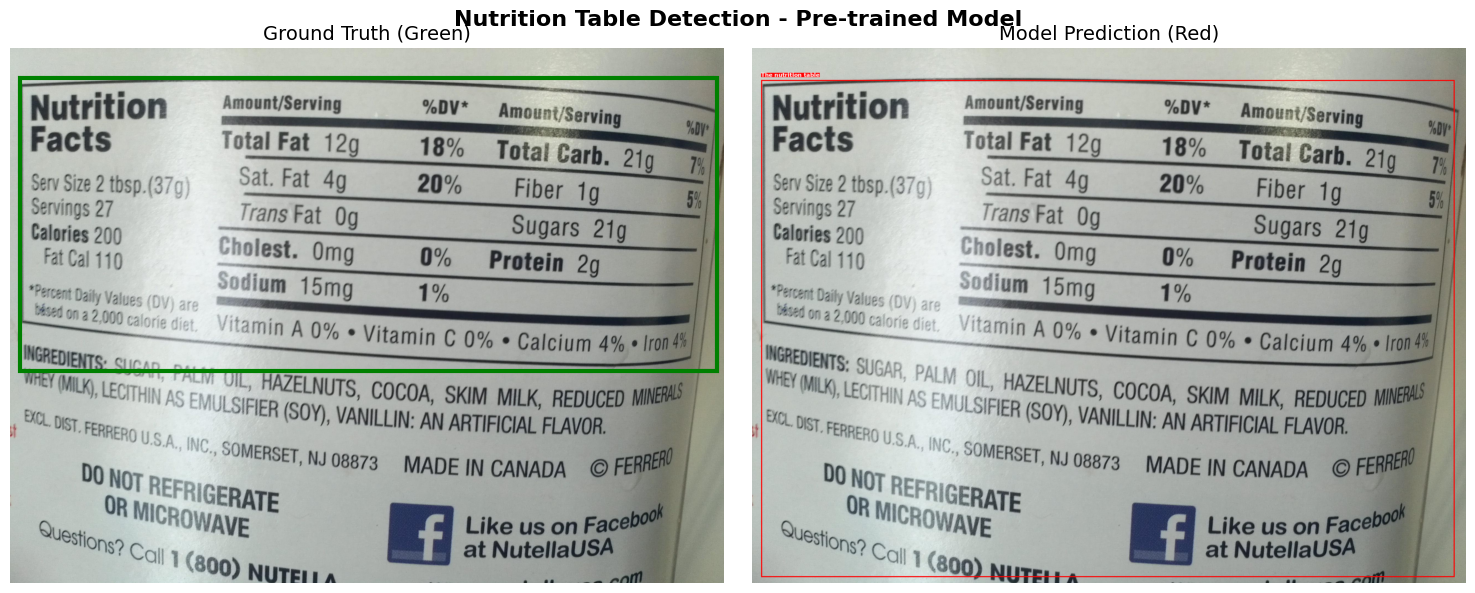

In [ ]:
# Now test the pre-trained model on a nutrition table image
print("\n" + "=" * 60)
print("TESTING PRE-TRAINED MODEL ON NUTRITION TABLE")
print("=" * 60)

# Get the first nutrition table example
example_idx = 0
example = train_dataset[example_idx]
nutrition_image = example['image']
ground_truth_bbox = example['objects']['bbox'][0]
ground_truth_category = example['objects']['category_name'][0]

print(f"\nUsing training example #{example_idx}")
print(f"Image size: {nutrition_image.size}")
print(f"Ground truth: {ground_truth_category}")

# Run inference
print("\nRunning inference...")
nutrition_response = run_qwen2vl_inference(
    nutrition_image,
    "Detect the bounding box of the nutrition table."
)
print(f"Model response: {nutrition_response}")

# Parse the output
parsed_nutrition = parse_qwen_bbox_output(nutrition_response)
print(f"Parsed bbox: {parsed_nutrition}")

# Visualize if parsing succeeded
if parsed_nutrition:
    # Create visualization
    img_with_nutrition_bbox = visualize_bbox_on_image(nutrition_image, parsed_nutrition, normalize_coords=True)
    
    # Show comparison
    _ = plt.figure(figsize=(15, 6))
    
    # Original with ground truth
    _ = plt.subplot(1, 2, 1)
    _ = plt.imshow(nutrition_image)
    
    # Draw ground truth rectangle
    # Use PIL image dimensions since we're drawing on the displayed image
    pil_width, pil_height = nutrition_image.size
    # CRITICAL: OpenFoodFacts uses [y_min, x_min, y_max, x_max] format
    y_min, x_min, y_max, x_max = ground_truth_bbox
    gt_x1 = int(x_min * pil_width)
    gt_y1 = int(y_min * pil_height)
    gt_x2 = int(x_max * pil_width)
    gt_y2 = int(y_max * pil_height)
    
    from matplotlib.patches import Rectangle
    ax = plt.gca()
    rect = Rectangle((gt_x1, gt_y1), gt_x2-gt_x1, gt_y2-gt_y1,
                     linewidth=3, edgecolor='green', facecolor='none')
    ax.add_patch(rect)
    _ = plt.title("Ground Truth (Green)", fontsize=14)
    _ = plt.axis('off')
    
    # Model prediction
    _ = plt.subplot(1, 2, 2)
    _ = plt.imshow(img_with_nutrition_bbox)
    _ = plt.title("Model Prediction (Red)", fontsize=14)
    _ = plt.axis('off')
    
    _ = plt.suptitle("Nutrition Table Detection - Pre-trained Model", fontsize=16, fontweight='bold')
    _ = plt.tight_layout()
    _ = plt.show()
    

else:
    print("\nFailed to parse bbox - the model likely couldn't detect the nutrition table.")

# Data preprocessing

The dataset requires conversion to be compatible with the Hugging Face (HF) library. Specifically, each sample must be reformatted into the OpenAI conversation format, comprising:

- Roles: system, user, and assistant
- User input: Provide an image and ask, "Detect the bounding box of the nutrition table."
- Assistant response: Format compatible with Qwen2-VL's detection question responses
    * See pages 7 and 43 of this [paper](https://arxiv.org/pdf/2409.12191) and  [Model Card](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct#more-usage-tips) for tips
    * Ensure inclusion of class name and bounding box coordinates using the proper special tokens.
    * Check the expected range of bb coordinates
    * Pay attention to the order of x,y coordinates as expected by Qwen

Here is an example system prompt:

In [ ]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from product images.
Your task is to analyze the provided product images and detect the nutrition tables in a certain format.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [ ]:
# Task: write a function to map each sample to a list of 3 dicts (one for each role)

def convert_to_conversation_format(example):
    """
    Convert a dataset example to Qwen2-VL conversation format.
    
    Why IMAGE_PLACEHOLDER?
    - HuggingFace dataset.map() needs serializable data (PIL images aren't)
    - The placeholder is replaced with the actual image during training (in collate_fn)
    - Image is stored separately at example['image'] to avoid duplication
    
    Coordinate Conversion:
    - Input: OpenFoodFacts [y_min, x_min, y_max, x_max] in [0,1]
    - Output: Qwen2-VL (x1,y1),(x2,y2) in [0,1000)
    
    Args:
        example: Dataset sample with 'image' and 'objects' fields
        
    Returns:
        Dict with 'messages' (conversation) and 'image' (PIL object)
    """
    # Validate input
    if 'objects' not in example or 'bbox' not in example['objects']:
        raise ValueError("Missing objects or bbox in example")
    
    # Extract nutrition table bounding boxes
    bboxes = example['objects']['bbox']
    categories = example['objects']['category_name']  # Fixed: 'category_name' not 'category'
    
    # Format the assistant response with Qwen2-VL special tokens
    # Convert normalized [0,1] bbox to Qwen's [0,1000) format
    assistant_responses = []
    for bbox, category in zip(bboxes, categories):
        # Validate bbox values are in [0,1] range (with small tolerance for rounding)
        if not all(-0.001 <= coord <= 1.001 for coord in bbox):
            print(f"Warning: bbox coordinates out of [0,1] range: {bbox}")
        
        # CRITICAL: OpenFoodFacts uses [y_min, x_min, y_max, x_max] format
        # But Qwen2VL expects (x_top_left, y_top_left), (x_bottom_right, y_bottom_right)
        y_min, x_min, y_max, x_max = bbox  # Unpack OpenFoodFacts format
        
        # Convert to Qwen format: (x,y) coordinates in [0,1000) range
        # Note: multiply by 1000 to convert from [0,1] to [0,1000)
        x1 = int(x_min * 1000)  # x_top_left
        y1 = int(y_min * 1000)  # y_top_left
        x2 = int(x_max * 1000)  # x_bottom_right
        y2 = int(y_max * 1000)  # y_bottom_right
        
        # Format: <|object_ref_start|>object<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>
        response = f"<|object_ref_start|>{category}<|object_ref_end|><|box_start|>({x1},{y1}),({x2},{y2})<|box_end|>"
        assistant_responses.append(response)
    
    # Combine multiple detections if present
    assistant_text = " ".join(assistant_responses)
    
    # Create conversation format WITHOUT the PIL image embedded
    conversation = [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ]
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": "IMAGE_PLACEHOLDER"  # Use placeholder instead of actual image
                },
                {
                    "type": "text",
                    "text": "Detect the bounding box of the nutrition table."
                }
            ]
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": assistant_text
                }
            ]
        }
    ]
    
    # Return messages and image separately
    return {
        "messages": conversation,
        "image": example['image']  # Store PIL image at top level
    }

Now, let's format the data using the chatbot structure. This will allow us to set up the interactions appropriately for our model.


In [ ]:
def _has_image(example):
    """
    Filter out samples with missing or invalid images.
    
    This function is crucial for preventing None values from leaking into
    process_vision_info during collation/training, which would cause crashes.
    
    Why this is necessary:
    - Some dataset samples may have corrupted or missing images
    - PIL Image loading can fail silently, leaving None values
    - The collate_fn and process_vision_info expect valid PIL images
    - Filtering ensures training stability and prevents runtime errors
    
    Args:
        example: Dataset sample that should contain an 'image' field
    
    Returns:
        bool: True if example has a valid PIL image with 'size' attribute
    """
    img = example.get('image')
    try:
        # Treat as valid only if it looks like a PIL image
        return (img is not None) and hasattr(img, 'size')
    except Exception:
        return img is not None

# Apply filtering before formatting
train_dataset = train_dataset.filter(_has_image)
eval_dataset = eval_dataset.filter(_has_image)

# Task: apply the function above to all samples in the training and eval datasets
# Use remove_columns to get clean output with only 'messages' and 'image' fields
columns_to_remove = ['image_id', 'width', 'height', 'meta', 'objects']

# Unfortunately, HuggingFace datasets adds None fields during serialization of nested dicts
# This is a known behavior. We have two options:
# Option 1: Accept the None fields (they don't affect training, collate_fn handles them)
# Option 2: Post-process to remove them (adds overhead but cleaner)

# For now, using Option 1 - the collate_fn already handles None values correctly
train_dataset_formatted = train_dataset.map(
    convert_to_conversation_format,
    remove_columns=columns_to_remove
)
eval_dataset_formatted = eval_dataset.map(
    convert_to_conversation_format, 
    remove_columns=columns_to_remove
)

print(f"Formatted training samples: {len(train_dataset_formatted)}")
print(f"Formatted evaluation samples: {len(eval_dataset_formatted)}")

# NOTE: HuggingFace automatically adds 'image': None and 'text': None to content items
# This is expected behavior and the collate_fn handles it correctly

Formatted training samples: 1083
Formatted evaluation samples: 123


In [ ]:
# IMPORTANT DISCOVERY: None fields cannot be removed from HuggingFace Datasets!
# See IMPORTANT_LESSON.md for full explanation
# 
# Key points:
# 1. HuggingFace uses Apache Arrow which enforces schema consistency
# 2. Dataset.from_list() will ALWAYS add None fields back for nested dicts with varying keys
# 3. The None fields don't affect training - collate_fn handles them correctly
# 4. This is only a cosmetic issue when inspecting the dataset
#
# We keep the current approach: use .map() with remove_columns for efficiency
# The collate_fn (lines 2463-2468) properly filters out None values during training

# Simple check - just print what convert_to_conversation_format produces
print("\n" + "="*60)
print("Sample 0 after conversion:")
print("="*60)
sample = convert_to_conversation_format(train_dataset[0])
print(sample)

print("\n" + "="*60)
print("Sample 1 after conversion:")
print("="*60)
sample2 = convert_to_conversation_format(train_dataset[1])
print(sample2)


Sample 0 after conversion:
{'messages': [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a Vision Language Model specialized in interpreting visual data from product images.\nYour task is to analyze the provided product images and detect the nutrition tables in a certain format.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': 'IMAGE_PLACEHOLDER'}, {'type': 'text', 'text': 'Detect the bounding box of the nutrition table.'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': '<|object_ref_start|>nutrition-table<|object_ref_end|><|box_start|>(14,57),(991,603)<|box_end|>'}]}], 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x71392C95BE50>}

Sample 1 after conversion:
{'messages': [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a Vision Language Model specialized in 

In [ ]:
# Display the same samples with better formatting (line breaks)
from pprint import pprint

print("\n" + "="*60)
print("Sample 0 - Better formatted")
print("="*60)
print()
pprint(sample)

print("\n" + "="*60)
print("Sample 1 - Better formatted")
print("="*60)
print()
pprint(sample2)


Sample 0 - Better formatted

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x71392C95BE50>,
 'messages': [{'content': [{'text': 'You are a Vision Language Model '
                                    'specialized in interpreting visual data '
                                    'from product images.\n'
                                    'Your task is to analyze the provided '
                                    'product images and detect the nutrition '
                                    'tables in a certain format.\n'
                                    'Focus on delivering accurate, succinct '
                                    'answers based on the visual information. '
                                    'Avoid additional explanation unless '
                                    'absolutely necessary.',
                            'type': 'text'}],
               'role': 'system'},
              {'content': [{'image': 'IMAGE_PLACEHOLDER', 'type': '

In [ ]:
# Show what happens after apply_chat_template
print("\n" + "="*60)
print("After apply_chat_template")
print("="*60)

# Load processor to apply chat template
from transformers import Qwen2VLProcessor
processor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

# Apply chat template to sample 0
text_sample0 = processor.apply_chat_template(
    sample['messages'], 
    tokenize=False, 
    add_generation_prompt=False  # False for training
)
print("\nSample 0 after apply_chat_template:")
print(text_sample0)

# Apply chat template to sample 1
text_sample1 = processor.apply_chat_template(
    sample2['messages'],
    tokenize=False,
    add_generation_prompt=False
)
print("\n" + "="*60)
print("\nSample 1 after apply_chat_template:")
print(text_sample1)


After apply_chat_template

Sample 0 after apply_chat_template:
<|im_start|>system
You are a Vision Language Model specialized in interpreting visual data from product images.
Your task is to analyze the provided product images and detect the nutrition tables in a certain format.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Detect the bounding box of the nutrition table.<|im_end|>
<|im_start|>assistant
<|object_ref_start|>nutrition-table<|object_ref_end|><|box_start|>(14,57),(991,603)<|box_end|><|im_end|>



Sample 1 after apply_chat_template:
<|im_start|>system
You are a Vision Language Model specialized in interpreting visual data from product images.
Your task is to analyze the provided product images and detect the nutrition tables in a certain format.
Focus on delivering accurate, succinct answers based on the visual inf

In [ ]:
# Inspect the first two elements of train_dataset_formatted (what actually goes to DataLoader)
print("\n" + "="*80)
print("INSPECTING train_dataset_formatted - ACTUAL DATASET PASSED TO TRAINER")
print("="*80)

# Simple inspection first
for i in range(2):
    print(f"\nSample {i}:")
    print(train_dataset_formatted[i])
    print("-" * 50)


INSPECTING train_dataset_formatted - ACTUAL DATASET PASSED TO TRAINER

Sample 0:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x71392C983A90>, 'messages': [{'content': [{'image': None, 'text': 'You are a Vision Language Model specialized in interpreting visual data from product images.\nYour task is to analyze the provided product images and detect the nutrition tables in a certain format.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.', 'type': 'text'}], 'role': 'system'}, {'content': [{'image': 'IMAGE_PLACEHOLDER', 'text': None, 'type': 'image'}, {'image': None, 'text': 'Detect the bounding box of the nutrition table.', 'type': 'text'}], 'role': 'user'}, {'content': [{'image': None, 'text': '<|object_ref_start|>nutrition-table<|object_ref_end|><|box_start|>(14,57),(991,603)<|box_end|>', 'type': 'text'}], 'role': 'assistant'}]}
---------------------------------

In [ ]:
# Display the same train_dataset_formatted samples with better formatting
from pprint import pprint

print("\n" + "="*60)
print("train_dataset_formatted[0] - Better formatted")
print("="*60)
print()
formatted_sample_0 = train_dataset_formatted[0]
pprint(formatted_sample_0)

print("\n" + "="*60)
print("train_dataset_formatted[1] - Better formatted")
print("="*60)
print()
formatted_sample_1 = train_dataset_formatted[1]
pprint(formatted_sample_1)

#
# Before we proceed with training the model in the next section, let's clear the current variables and clean the GPU to free up resources.
#
#


train_dataset_formatted[0] - Better formatted

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x71392C9B80A0>,
 'messages': [{'content': [{'image': None,
                            'text': 'You are a Vision Language Model '
                                    'specialized in interpreting visual data '
                                    'from product images.\n'
                                    'Your task is to analyze the provided '
                                    'product images and detect the nutrition '
                                    'tables in a certain format.\n'
                                    'Focus on delivering accurate, succinct '
                                    'answers based on the visual information. '
                                    'Avoid additional explanation unless '
                                    'absolutely necessary.',
                            'type': 'text'}],
               'role': 'system'},
      

In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.01 GB


In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mon Aug 25 11:15:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off |   00000000:01:00.0 Off |                  Off |
| 30%   44C    P2             75W /  300W |     533MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load the Model for Training with NF4 weights  ⚙️

Next, you need to load the quantized model using [bitsandbytes](https://huggingface.co/docs/bitsandbytes/main/en/index). If you want to learn more about quantization, check out [this blog post](https://huggingface.co/blog/merve/quantization) or [this one](https://www.maartengrootendorst.com/blog/quantization/).


In [ ]:
# TASK: load the NF4 model and processor
from transformers import BitsAndBytesConfig, Qwen2VLForConditionalGeneration, Qwen2VLProcessor
import torch

# Configure 4-bit quantization for QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

model_id = "Qwen/Qwen2-VL-7B-Instruct"

# Load the model with 4-bit quantization
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",  # Use Flash Attention 2 for efficiency
    trust_remote_code=True,
)

# Load processor
processor = Qwen2VLProcessor.from_pretrained(
    model_id,
    trust_remote_code=True,
)

print(f"Model loaded: {model_id}")
print(f"Model device map: {model.hf_device_map}")
print(f"Model memory footprint: {model.get_memory_footprint() / 1024**3:.2f} GB")



Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model loaded: Qwen/Qwen2-VL-7B-Instruct
Model device map: {'model.visual': 0, 'model.language_model.embed_tokens': 0, 'model.language_model.layers.0': 0, 'model.language_model.layers.1': 0, 'model.language_model.layers.2': 0, 'model.language_model.layers.3': 0, 'model.language_model.layers.4': 0, 'model.language_model.layers.5': 1, 'model.language_model.layers.6': 1, 'model.language_model.layers.7': 1, 'model.language_model.layers.8': 1, 'model.language_model.layers.9': 1, 'model.language_model.layers.10': 1, 'model.language_model.layers.11': 1, 'model.language_model.layers.12': 1, 'model.language_model.layers.13': 1, 'model.language_model.layers.14': 1, 'model.language_model.layers.15': 1, 'model.language_model.layers.16': 1, 'model.language_model.layers.17': 1, 'model.language_model.layers.18': 1, 'model.language_model.layers.19': 1, 'model.language_model.layers.20': 1, 'model.language_model.layers.21': 1, 'model.language_model.layers.22': 1, 'model.language_model.layers.23': 1, 'mod

'\n# Resize model embeddings to match tokenizer\n# This fixes the CUDA error caused by token IDs outside vocab range\nprint(f"\nChecking tokenizer and model vocab size...")\nprint(f"Tokenizer vocab size: {processor.tokenizer.vocab_size}")\nprint(f"Tokenizer length (with special tokens): {len(processor.tokenizer)}")\nprint(f"Model embedding size: {model.get_input_embeddings().weight.shape[0]}")\n\n# Resize if needed\nif len(processor.tokenizer) > model.get_input_embeddings().weight.shape[0]:\n    print(f"Resizing model embeddings from {model.get_input_embeddings().weight.shape[0]} to {len(processor.tokenizer)}")\n    model.resize_token_embeddings(len(processor.tokenizer))\nelse:\n    print("No resizing needed - model embeddings already large enough")\n'

In [ ]:
# IMPORTANT: For TRL version 0.12.0, we need to manually prepare the model before LoRA
# Newer versions (0.21+) do this automatically, but 0.12.0 does not
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
print("✅ Model prepared for k-bit training")

✅ Model prepared for k-bit training


## Set Up QLoRA and SFTConfig 🚀

Next, you need to configure [QLoRA](https://github.com/artidoro/qlora) for your training setup. QLoRA enables efficient fine-tuning of large language models while significantly reducing the memory footprint compared to traditional methods. Unlike standard LoRA, which reduces memory usage by applying a low-rank approximation, QLoRA takes it a step further by quantizing the model weights. This leads to even lower memory requirements and improved training efficiency, making it an excellent choice for optimizing our model's performance without sacrificing quality.

💡 NOTE:

Preparing a model for QLoRA training typically involves three key steps:

- Load the base model in 4-bit (using BitsAndBytesConfig).

- Run prepare_model_for_kbit_training(). 🚨 Understand what this function does.

- Apply LoRA adapters to the target modules.

You can perform these steps manually, or let SFTTrainer handle steps 2 & 3 for you:

- Simply load the model in 4-bit,

- Pass a peft_config to SFTTrainer, which will automatically run prepare_model_for_kbit_training() (for unsharded QLoRA) and attach LoRA adapters. See lines 610 and 625 in [here](https://github.com/huggingface/trl/blob/v0.21.0/trl/trainer/sft_trainer.py)





In [ ]:
from peft import LoraConfig, get_peft_model
# Task: create LoRA config and apply LoRA to the model instrance created above

# Configure LoRA
lora_config = LoraConfig(
    r=64,  # Rank
    lora_alpha=128,  # Alpha scaling
    lora_dropout=0.1,  # Dropout probability
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",  # Attention layers
        "gate_proj", "up_proj", "down_proj",  # MLP layers
    ],
)

print("LoRA Configuration:")
print(f"  Rank (r): {lora_config.r}")
print(f"  Alpha: {lora_config.lora_alpha}")
print(f"  Dropout: {lora_config.lora_dropout}")
print(f"  Target modules: {lora_config.target_modules}")

# For TRL 0.12.0, we need to manually apply get_peft_model
model = get_peft_model(model, lora_config)
print("\n✅ LoRA adapters attached to model")
model.print_trainable_parameters()

LoRA Configuration:
  Rank (r): 64
  Alpha: 128
  Dropout: 0.1
  Target modules: {'o_proj', 'k_proj', 'v_proj', 'gate_proj', 'q_proj', 'down_proj', 'up_proj'}

✅ LoRA adapters attached to model
trainable params: 161,480,704 || all params: 8,452,856,320 || trainable%: 1.9104


Next, you need to create an SFT config for model finetuning. This step is critical for model convergence.
You should set the following hyper-parameteres among others:
 - learning_rate
 - per_device_train_batch_size
 - gradient_accumulation_steps for better gradient direction estimation
 - BF16 and TF32 enablement for memory saving and faster compute
 - gradient_checkpointing for memory saving
   
There are other input arguments that you should also set for proper evaluation during model finetuning.

In [ ]:
from trl import SFTConfig
# TASK: create an SFT config

training_args = SFTConfig(
    # Output and logging - SAVE TO SSD TO AVOID HOME DIRECTORY QUOTA
    output_dir="/ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora",
    logging_dir="/ssd1/zhuoyuan/vlm_outputs/logs",
    logging_steps=10,
    
    # Training hyperparameters
    num_train_epochs=3,
    per_device_train_batch_size=2,  # Adjust based on GPU memory
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,  # Effective batch size = 2 * 8 = 16
    gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
    
    # Learning rate and optimization
    learning_rate=2e-4,
    warmup_steps=100,
    lr_scheduler_type="cosine",
    optim="adamw_torch",
    adam_beta2=0.999,
    weight_decay=0.01,
    max_grad_norm=1.0,
    
    # Mixed precision and performance
    bf16=True,  # Use bfloat16 precision
    tf32=True,  # Enable TF32 on Ampere GPUs
    dataloader_num_workers=0,
    
    # Evaluation and saving
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=300,  # Changed from 100 to 300 - fewer checkpoints
    save_total_limit=3,  # Only keep last 3 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    
    # Other settings
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="wandb",  # Use W&B for logging metrics (changed from tensorboard)
    run_name="qwen2vl-nutrition-detection",
    seed=42,  # For reproducibility
    
    # Specific for vision models
    dataset_text_field="",  # Empty string because we use custom data_collator, not "messages"
    # Note: dataset_text_field would be "messages" if we wanted SFTTrainer to handle text extraction,
    # but we handle everything in our custom collate_fn, so we leave it empty
    max_length=2048,
    dataset_kwargs={
        "skip_prepare_dataset": True  # We handle data preparation ourselves
    },
)

print("Training Configuration:")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size per device: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation steps: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Number of epochs: {training_args.num_train_epochs}")
print(f"  Random seed: {training_args.seed}")

Training Configuration:
  Learning rate: 0.0002
  Batch size per device: 2
  Gradient accumulation steps: 8
  Effective batch size: 16
  Number of epochs: 3
  Random seed: 42


# wandb setup
If you have wandb account, you can set it up here.
Let’s connect our notebook to W&B to capture essential information during training.
Make sure to have set the logging arguments in the SFT config.


In [ ]:
# Initialize W&B for experiment tracking
import wandb

wandb.login()  # reads the key from the env

# Initialize Weights & Biases for experiment tracking
wandb.init(
    project="qwen2vl-nutrition-detection",
    name="qwen2vl-7b-nutrition-lora",
    config={
        "model": model_id,
        "lora_r": lora_config.r,
        "lora_alpha": lora_config.lora_alpha,
        "learning_rate": training_args.learning_rate,
        "batch_size": training_args.per_device_train_batch_size,
        "gradient_accumulation": training_args.gradient_accumulation_steps,
        "epochs": training_args.num_train_epochs,
        "dataset": "openfoodfacts/nutrition-table-detection",
    },
    tags=["qwen2-vl", "object-detection", "nutrition-table", "lora"],
)

print("✅ W&B initialized for experiment tracking")
print(f"View your run at: {wandb.run.get_url()}")

wandb: Currently logged in as: zhuoyuan-jiang-yale (zhuoyuan-jiang-yale-yale-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


✅ W&B initialized for experiment tracking
View your run at: https://wandb.ai/zhuoyuan-jiang-yale-yale-university/qwen2vl-nutrition-detection/runs/t5ry1vrc


## Training the Model 🏃

You should now create a trainer object by instantiating the SFTTrainer class of HF's TRL. For this, you need to provide the training dataset, model, tokenizer, and more important a collate function.

You need a collator function to properly retrieve and batch the data during the training procedure. This function will receive as the input a batch of samples:

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from product images.\nYour task is to analyze the provided product images and detect the nutrition tables in a certain format. \nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944>},
   {'type': 'text',
    'text': 'Detect the bounding box of the nutrition table'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': '<|object_ref_start|>the nutrition table<|object_ref_end|><|box_start|>(14,57),(991,604)<|box_end|>'}]}]
    
[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from product images.\nYour task is to analyze the provided product images and detect the nutrition tables in a certain format. \nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=306x408>},
   {'type': 'text',
    'text': 'Detect the bounding box of the nutrition table'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': '<|object_ref_start|>the nutrition table<|object_ref_end|><|box_start|>(147,152),(516,588)<|box_end|>'}]}]

and then performs ops similar to what we did earlier in the inference script:
  - applying chat template on each sample in the batch -> get formatted prompt
  - applying process_vision_info on each sample in the batch -> get image pixels
  - applying processor on formatted prompt and image pixels -> new batch
  - modify the labels of the new batch by replacing labels correspondings to the following items to -100 (why?)
    * text pad tokens
    * <|vision_start|> <|vision_end|> <|image_pad|>

👉 Check out the TRL official example [scripts]( https://github.com/huggingface/trl/blob/main/examples/scripts/sft_vlm.py#L87) for more details.


## Data Collator Function

The collator function is critical for properly batching text-image pairs during training.
It handles the conversion from our formatted dataset to the format expected by the model.

In [ ]:
# Original collate_fn - simpler version without advanced fixes
def collate_fn(batch):
    """
    Data collator for Qwen2-VL that processes text-image pairs for training.
    
    Args:
        batch: List of samples from the dataset, each containing 'messages' and 'image'
        
    Returns:
        Dict with input_ids, attention_mask, pixel_values, and labels
    """
    # Extract messages and images from each sample
    messages_list = [sample['messages'] for sample in batch]
    images_list = [sample.get('image', None) for sample in batch]  # Images are now at top level

    # Drop any entries without an image to avoid None in process_vision_info
    valid_pairs = [(m, img) for m, img in zip(messages_list, images_list) if img is not None]
    if not valid_pairs:
        raise ValueError("Batch contains no valid images.")
    if len(valid_pairs) != len(batch):
        print(f"[collate_fn] Dropped {len(batch) - len(valid_pairs)} samples without images in this batch")
    messages_list, images_list = zip(*valid_pairs)
    messages_list = list(messages_list)
    images_list = list(images_list)
    
    # Apply chat template to each conversation
    texts = []
    all_images = []
    
    print("[collate_fn] Using hardened collator v2")

    for i, messages in enumerate(messages_list):
        # We need to restore the actual image in messages for process_vision_info
        messages_with_image = []
        for msg in messages:
            msg_copy = msg.copy()
            # Scan and restore for all roles, not just 'user'
            content_copy = []
            for content in msg['content']:
                content_item = content.copy()
                if content_item.get('type') == 'image':
                    if content_item.get('image') == 'IMAGE_PLACEHOLDER' or content_item.get('image') is None:
                        if images_list[i] is not None:
                            content_item['image'] = images_list[i]
                        else:
                            continue
                content_copy.append(content_item)
            msg_copy['content'] = content_copy
            messages_with_image.append(msg_copy)
        
        # Apply chat template
        text = processor.apply_chat_template(
            messages_with_image, 
            tokenize=False, 
            add_generation_prompt=False
        )
        texts.append(text)

        # Build image inputs per sample using process_vision_info
        try:
            image_inputs, _ = process_vision_info(messages_with_image)
        except Exception as e:
            print(f"[collate_fn] process_vision_info failed for sample {i}: {e}")
            image_inputs = [images_list[i]] if images_list[i] is not None else []
        all_images.extend(image_inputs)
    
    # Process all texts and images together using aligned image inputs
    if any(img is None for img in all_images):
        raise ValueError("[collate_fn] all_images contains None after vision processing")

    # Optional: sanity check placeholder/image alignment
    image_token = getattr(processor, 'image_token', '<|image_pad|>')
    total_placeholders = sum(t.count(image_token) for t in texts)
    if total_placeholders != len(all_images):
        print(f"[collate_fn] Note: placeholders={total_placeholders}, images={len(all_images)}")

    batch_inputs = processor(
        text=texts,
        images=all_images,
        videos=None,
        padding=True,
        truncation=True,
        max_length=2048,
        return_tensors="pt"
    )
    
    # Create labels for training (copy input_ids)
    labels = batch_inputs["input_ids"].clone()
    
    # Mask padding tokens in labels
    labels[labels == processor.tokenizer.pad_token_id] = -100
    
    # Mask image tokens in labels to not compute loss on them
    # Find and mask special vision tokens
    if hasattr(processor, "image_token_id"):
        labels[labels == processor.image_token_id] = -100
    
    # Find and mask vision start/end tokens
    special_tokens_to_mask = ["<|vision_start|>", "<|vision_end|>", "<|image_pad|>"]
    for special_token in special_tokens_to_mask:
        if special_token in processor.tokenizer.get_vocab():
            token_id = processor.tokenizer.convert_tokens_to_ids(special_token)
            labels[labels == token_id] = -100
    
    # Also mask the system and user parts, keeping only assistant response for loss
    # This is done by finding the assistant token positions
    for i, text in enumerate(texts):
        # Find where assistant response starts
        assistant_start = text.find("assistant") 
        if assistant_start != -1:
            # Tokenize just the part before assistant response
            prefix_tokens = processor.tokenizer(
                text[:assistant_start],
                add_special_tokens=False,
                return_tensors="pt"
            )
            prefix_len = prefix_tokens["input_ids"].shape[1]
            
            # Mask everything before the assistant response
            if prefix_len < labels.shape[1]:
                labels[i, :prefix_len] = -100
    
    batch_inputs["labels"] = labels
    
    return batch_inputs

print("Original collate_fn created")

Original collate_fn created


In [ ]:
# Fixed collate_fn with improved error handling and robust masking  
def collate_fn_fixed(batch):
    """
    FIXED VERSION: Robust collate function that prevents out-of-range label issues.
    
    This collator:
    1. Restores IMAGE_PLACEHOLDER with actual PIL images
    2. Uses process_vision_info to properly extract and format images
    3. Applies chat template to get formatted text
    4. Tokenizes text and processes images together
    5. Creates labels with proper masking for loss computation
    
    Key improvements:
    - Properly masks all vision/special tokens to prevent training on them
    - Validates that no out-of-vocabulary tokens exist in labels
    - Uses token-based span finding for robust assistant response extraction
    - Handles edge cases gracefully (samples without images, OOV tokens)
    
    Args:
        batch: List of samples from the dataset, each containing 'messages' and 'image'
        
    Returns:
        Dict with input_ids, attention_mask, pixel_values, image_grid_thw, and labels
    """
    # Extract messages and images from each sample
    messages_list = [sample['messages'] for sample in batch]
    images_list = [sample.get('image', None) for sample in batch]
    
    # Filter out samples without images
    valid_pairs = [(m, img) for m, img in zip(messages_list, images_list) if img is not None]
    if not valid_pairs:
        raise ValueError("Batch contains no valid images.")
    
    messages_list, images_list = zip(*valid_pairs)
    messages_list = list(messages_list)
    images_list = list(images_list)
    
    # Process each sample
    texts = []
    all_images = []
    
    for messages, image in zip(messages_list, images_list):
        # Clean up messages: remove None values and restore images
        messages_with_image = []
        for msg in messages:
            msg_copy = {'role': msg['role'], 'content': []}
            
            for content_item in msg['content']:
                # Process text content
                if content_item.get('type') == 'text':
                    if content_item.get('text'):  # Only add if text exists
                        msg_copy['content'].append({
                            'type': 'text',
                            'text': content_item['text']
                        })
                # Process image content - only add to user messages
                elif content_item.get('type') == 'image' and msg['role'] == 'user':
                    msg_copy['content'].append({
                        'type': 'image',
                        'image': image  # Use the actual PIL image
                    })
            
            if msg_copy['content']:
                messages_with_image.append(msg_copy)
        
        # Apply chat template
        text = processor.apply_chat_template(
            messages_with_image,
            tokenize=False,
            add_generation_prompt=False
        )
        texts.append(text)
        all_images.append(image)
    
    # Process texts and images together
    batch_inputs = processor(
        text=texts,
        images=all_images,
        videos=None,
        padding=True,
        truncation=False,
        return_tensors="pt"
    )
    
    # Create labels from input_ids
    labels = batch_inputs["input_ids"].clone()
    
    # Get vocabulary size for validation
    vocab_size = processor.tokenizer.vocab_size
    
    # CRITICAL: Check for out-of-vocabulary tokens and handle them
    oov_mask = batch_inputs["input_ids"] >= vocab_size
    if oov_mask.any():
        print(f"[collate_fn] WARNING: Found {oov_mask.sum().item()} out-of-vocabulary tokens")
        # Replace OOV tokens with UNK token in input_ids
        if processor.tokenizer.unk_token_id is not None:
            batch_inputs["input_ids"][oov_mask] = processor.tokenizer.unk_token_id
        # Always mask OOV tokens in labels
        labels[oov_mask] = -100
    
    # Step 1: Collect all special token IDs to mask
    special_token_ids = set()
    
    # Add padding token
    if processor.tokenizer.pad_token_id is not None:
        special_token_ids.add(processor.tokenizer.pad_token_id)
    
    # Add vision and chat special tokens
    special_token_strings = [
        "<|vision_start|>", "<|vision_end|>", "<|image_pad|>", "<|video_pad|>",
        "<|im_start|>", "<|im_end|>",
        "<|object_ref_start|>", "<|object_ref_end|>", 
        "<|box_start|>", "<|box_end|>"
    ]
    
    for token_str in special_token_strings:
        if token_str in processor.tokenizer.get_vocab():
            token_id = processor.tokenizer.convert_tokens_to_ids(token_str)
            if token_id is not None and 0 <= token_id < vocab_size:
                special_token_ids.add(token_id)
    
    # Add image token if it exists
    if hasattr(processor, "image_token_id") and processor.image_token_id is not None:
        special_token_ids.add(processor.image_token_id)
    
    # Step 2: Mask all special tokens
    for token_id in special_token_ids:
        labels[labels == token_id] = -100
    
    # Step 3: Find and unmask only assistant responses (token-based approach)
    # Encode the markers to token IDs
    assistant_start_text = "<|im_start|>assistant\n"
    assistant_end_text = "<|im_end|>"
    
    try:
        assistant_start_ids = processor.tokenizer.encode(assistant_start_text, add_special_tokens=False)
        assistant_end_ids = processor.tokenizer.encode(assistant_end_text, add_special_tokens=False)
    except:
        # Fallback if encoding fails
        assistant_start_ids = []
        assistant_end_ids = []
    
    if assistant_start_ids and assistant_end_ids:
        # Helper function to find token sequence
        def find_token_sequence(tokens, sequence, start_pos=0):
            seq_len = len(sequence)
            for i in range(start_pos, len(tokens) - seq_len + 1):
                if tokens[i:i + seq_len].tolist() == sequence:
                    return i
            return -1
        
        # Process each sequence in the batch
        for batch_idx in range(labels.shape[0]):
            input_ids_list = batch_inputs["input_ids"][batch_idx]
            
            # Initially mask everything for this sequence
            labels[batch_idx, :] = -100
            
            # Find all assistant response spans
            pos = 0
            while pos < len(input_ids_list):
                # Find start of assistant response
                start_pos = find_token_sequence(input_ids_list, assistant_start_ids, pos)
                if start_pos == -1:
                    break
                
                # Find end of assistant response
                response_start = start_pos + len(assistant_start_ids)
                end_pos = find_token_sequence(input_ids_list, assistant_end_ids, response_start)
                
                if end_pos == -1:
                    # No end marker found, unmask to the end
                    end_pos = len(input_ids_list)
                
                # Unmask the assistant response (but not special tokens)
                for idx in range(response_start, end_pos):
                    token_id = input_ids_list[idx].item()
                    # Only unmask if it's not a special token and within vocab range
                    if token_id not in special_token_ids and 0 <= token_id < vocab_size:
                        labels[batch_idx, idx] = token_id
                
                # Move past this response
                pos = end_pos + len(assistant_end_ids) if end_pos < len(input_ids_list) else len(input_ids_list)
    else:
        # Fallback: If we can't find markers, mask everything except non-special tokens
        print("[collate_fn] Warning: Could not encode assistant markers, using fallback masking")
        # This will train on all text tokens except special ones
        for token_id in special_token_ids:
            labels[labels == token_id] = -100
    
    # Final validation: Ensure all unmasked labels are within vocabulary range
    valid_labels = labels[labels != -100]
    if valid_labels.numel() > 0:
        max_label = valid_labels.max().item()
        if max_label >= vocab_size:
            print(f"[collate_fn] ERROR: Found label {max_label} >= vocab_size {vocab_size}")
            # Mask any remaining out-of-range labels
            labels[labels >= vocab_size] = -100
    
    # Add labels to batch
    batch_inputs["labels"] = labels
    
    return batch_inputs

print("✅ Fixed collate_fn created")

✅ Fixed collate_fn created


In [ ]:
# DEBUG: Test the collate_fn with actual data samples
print("\n" + "="*60)
print("DEBUG: Testing collate_fn with first two samples from train_dataset_formatted")
print("="*60)

# Get first two samples from the dataset
sample0 = train_dataset_formatted[0]
sample1 = train_dataset_formatted[1]

# Create a test batch
test_batch = [sample0, sample1]

print(f"Sample 0 keys: {sample0.keys()}")
print(f"Sample 1 keys: {sample1.keys()}")
print(f"Sample 0 has image: {sample0.get('image') is not None}")
print(f"Sample 1 has image: {sample1.get('image') is not None}")

# Test the collate_fn
try:
    print("\nCalling collate_fn with test batch...")
    result = collate_fn(test_batch)
    print("✓ collate_fn executed successfully!")
    
    print(f"\nResult keys: {result.keys()}")
    print(f"Input IDs shape: {result['input_ids'].shape}")
    print(f"Attention mask shape: {result['attention_mask'].shape}")
    print(f"Labels shape: {result['labels'].shape}")
    
    if 'pixel_values' in result:
        print(f"Pixel values shape: {result['pixel_values']['pixel_values'].shape}")
        print(f"Image grid thw shape: {result['pixel_values']['image_grid_thw'].shape}")
    
    # Check if labels are properly masked
    num_masked = (result['labels'] == -100).sum().item()
    total_tokens = result['labels'].numel()
    print(f"\nLabel masking: {num_masked}/{total_tokens} tokens masked ({num_masked/total_tokens*100:.1f}%)")
    
except Exception as e:
    print(f"✗ Error in collate_fn: {e}")
    import traceback
    traceback.print_exc()

print("="*60 + "\n")


DEBUG: Testing collate_fn with first two samples from train_dataset_formatted
Sample 0 keys: dict_keys(['image', 'messages'])
Sample 1 keys: dict_keys(['image', 'messages'])
Sample 0 has image: True
Sample 1 has image: True

Calling collate_fn with test batch...
[collate_fn] Using hardened collator v2
[collate_fn] process_vision_info failed for sample 0: 'NoneType' object has no attribute 'startswith'
[collate_fn] process_vision_info failed for sample 1: 'NoneType' object has no attribute 'startswith'
[collate_fn] Note: placeholders=8, images=2
✗ Error in collate_fn: index 2 is out of bounds for dimension 0 with size 2



Traceback (most recent call last):
  File "/tmp/ipykernel_886622/3057849401.py", line 21, in <module>
    result = collate_fn(test_batch)
  File "/tmp/ipykernel_886622/2190491994.py", line 77, in collate_fn
    batch_inputs = processor(
  File "/home/zhuoyuan/miniconda3/envs/vlm_Qwen2VL_object_detection/lib/python3.10/site-packages/transformers/models/qwen2_vl/processing_qwen2_vl.py", line 161, in __call__
    num_image_tokens = image_grid_thw[index].prod() // merge_length
IndexError: index 2 is out of bounds for dimension 0 with size 2


In [ ]:
# Note: Using the consolidated collate_fn defined earlier in the notebook
# This function already includes all the fixes for out-of-range label issues

In [ ]:
# IMPORTANT: Use the fixed collate_fn for training to prevent out-of-range label issues
collate_fn = collate_fn_fixed
print("✅ Switched to using collate_fn_fixed for training")

✅ Switched to using collate_fn_fixed for training


In [ ]:
from trl import SFTTrainer
# TASK: Create the SFT trainer and launch training

# Create the trainer
# For TRL 0.12.0: We already manually:
# 1. Called prepare_model_for_kbit_training()
# 2. Applied get_peft_model() with LoRA config
# So we DON'T pass peft_config to SFTTrainer (model is already a PEFT model)
trainer = SFTTrainer(
    model=model,  # Already a PEFT model with LoRA adapters
    args=training_args,
    train_dataset=train_dataset_formatted,
    eval_dataset=eval_dataset_formatted,
    data_collator=collate_fn,  # Using the FIXED collate_fn that prevents out-of-range labels
    processing_class=processor,  # Use full processor (not just tokenizer) for consistency
    # Note: NO peft_config here since we already applied get_peft_model manually
)

print("SFTTrainer created successfully")
print(f"Total training samples: {len(train_dataset_formatted)}")
print(f"Total evaluation samples: {len(eval_dataset_formatted)}")
print(f"Number of training steps: {len(train_dataset_formatted) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")

SFTTrainer created successfully
Total training samples: 1083
Total evaluation samples: 123
Number of training steps: 201


In [ ]:
print("collator_is_bound:", trainer.data_collator is collate_fn)
print("dataloader_num_workers:", training_args.dataloader_num_workers)
tmp_batch = [train_dataset_formatted[i] for i in range(2)]
_ = collate_fn(tmp_batch)
print("collate_fn manual batch OK")

collator_is_bound: True
dataloader_num_workers: 0
[collate_fn] WARNING: Found 12856 out-of-vocabulary tokens
collate_fn manual batch OK


Now, we will define the [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer), which is a wrapper around the [transformers.Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class and inherits its attributes and methods. This class simplifies the fine-tuning process by properly initializing the [PeftModel](https://huggingface.co/docs/peft/v0.6.0/package_reference/peft_model) when a [PeftConfig](https://huggingface.co/docs/peft/v0.6.0/en/package_reference/config#peft.PeftConfig) object is provided. By using `SFTTrainer`, we can efficiently manage the training workflow and ensure a smooth fine-tuning experience for our Vision Language Model.



In [ ]:

# Launch training
print("\nStarting training...")
trainer.train()

# Save the final model
print("\nSaving the fine-tuned model...")
trainer.save_model(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

print(f"Model saved to {training_args.output_dir}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.



Starting training...
[collate_fn] WARNING: Found 20383 out-of-vocabulary tokens
[collate_fn] WARNING: Found 32585 out-of-vocabulary tokens
[collate_fn] WARNING: Found 13515 out-of-vocabulary tokens
[collate_fn] WARNING: Found 5704 out-of-vocabulary tokens
[collate_fn] WARNING: Found 32141 out-of-vocabulary tokens
[collate_fn] WARNING: Found 20379 out-of-vocabulary tokens
[collate_fn] WARNING: Found 32583 out-of-vocabulary tokens
[collate_fn] WARNING: Found 13517 out-of-vocabulary tokens
[collate_fn] WARNING: Found 32585 out-of-vocabulary tokens


/home/zhuoyuan/miniconda3/envs/vlm_Qwen2VL_object_detection/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Casting fp32 inputs back to torch.bfloat16 for flash-attn compatibility.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# 5. Testing the Fine-Tuned Model 🔍

Now that we've successfully fine-tuned our Vision Language Model (VLM), it's time to evaluate its performance! In this section, we will test the model using examples from the ChartQA dataset to see how well it answers questions based on chart images. Let's dive in and explore the results! 🚀



Let's clean up the GPU memory to ensure optimal performance 🧹

In [ ]:
clear_memory()

We will reload the base model using the same pipeline as before, but this we will load the LoRA adpaters into the model too. LoRA adapters should be selected from the saved directory.

In [ ]:
# TASK:  Load model, processor, and adapter weights
from peft import PeftModel
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
import torch

# Path to saved LoRA adapters
adapter_path = "./qwen2vl-nutrition-detection-lora"

# Load the base model
base_model_id = "Qwen/Qwen2-VL-7B-Instruct"
model_finetuned = Qwen2VLForConditionalGeneration.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2",
)

# Load the LoRA adapters
model_finetuned = PeftModel.from_pretrained(
    model_finetuned,
    adapter_path,
    torch_dtype=torch.bfloat16,
)

# Load processor
processor_finetuned = Qwen2VLProcessor.from_pretrained(adapter_path)

print(f"Loaded fine-tuned model from {adapter_path}")
print(f"Model has {sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad):,} trainable parameters")

Test the fine-tuned model on the example above, where the model previously struggled to accurately locate the nutrition table.

In [ ]:
# TASK: test on the #20 training example
from qwen_vl_utils import process_vision_info
import matplotlib.pyplot as plt
from PIL import ImageDraw

# Get example #20 from training set
example_idx = 20
example = train_dataset[example_idx]
image = example['image']
ground_truth_bbox = example['objects']['bbox'][0]
ground_truth_category = example['objects']['category_name'][0]

# Create messages for inference
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {
                "type": "text",
                "text": "Detect the bounding box of the nutrition table.",
            },
        ],
    }
]

# Apply chat template
text = processor_finetuned.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

# Process vision information
image_inputs, video_inputs = process_vision_info(messages)

# Prepare inputs
inputs = processor_finetuned(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
).to(model_finetuned.device)

# Generate prediction
with torch.no_grad():
    generated_ids = model_finetuned.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,
    )

# Decode the output
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor_finetuned.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

print(f"Example #{example_idx}")
print(f"Ground truth category: {ground_truth_category}")
print(f"Ground truth bbox (normalized): {ground_truth_bbox}")
print(f"\nModel output: {output_text}")

# Parse the model output
parsed_bbox = parse_qwen_bbox_output(output_text)
if parsed_bbox:
    print(f"Parsed prediction: {parsed_bbox}")

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Ground truth
img_gt = image.copy()
draw_gt = ImageDraw.Draw(img_gt)
width, height = img_gt.size
# CRITICAL: OpenFoodFacts uses [y_min, x_min, y_max, x_max] format
y_min, x_min, y_max, x_max = ground_truth_bbox
x_min = x_min * width
y_min = y_min * height
x_max = x_max * width
y_max = y_max * height
draw_gt.rectangle([x_min, y_min, x_max, y_max], outline='green', width=3)

axes[0].imshow(img_gt)
axes[0].set_title(f"Ground Truth: {ground_truth_category}")
axes[0].axis('off')

# Model prediction
if parsed_bbox:
    img_pred = visualize_bbox_on_image(image, parsed_bbox, normalize_coords=True)
    axes[1].imshow(img_pred)
    axes[1].set_title(f"Model Prediction: {parsed_bbox['object']}")
else:
    axes[1].imshow(image)
    axes[1].set_title("Model Prediction: No detection")
axes[1].axis('off')

plt.tight_layout()
plt.show()

Since this sample is drawn from the training set, the model has encountered it during training, which may be seen as a form of cheating. To gain a more comprehensive understanding of the model's performance, you should also evaluate it using the eval dataset. For this, write an evaluation script that measures the IoU metric between the ground truth box and the predicted boundig box.


In [ ]:
# Task: write the eval function. You can use use ops.box_iou
from torchvision import ops
import numpy as np
from tqdm import tqdm

def evaluate_model(model, processor_model, dataset, num_samples=50):
    """
    Evaluate the model on a dataset using IoU metric.
    
    Args:
        model: The model to evaluate
        processor_model: The processor for the model
        dataset: The evaluation dataset
        num_samples: Number of samples to evaluate
        
    Returns:
        Dict with evaluation metrics
    """
    ious = []
    successful_detections = 0
    total_samples = min(num_samples, len(dataset))
    
    for idx in tqdm(range(total_samples), desc="Evaluating"):
        example = dataset[idx]
        image = example['image']
        ground_truth_bbox = example['objects']['bbox'][0]  # Take first bbox
        
        # Create messages for inference
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": "Detect the bounding box of the nutrition table."},
                ],
            }
        ]
        
        try:
            # Apply chat template
            text = processor_model.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            
            # Process vision information
            image_inputs, video_inputs = process_vision_info(messages)
            
            # Prepare inputs
            inputs = processor_model(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt"
            ).to(model.device)
            
            # Generate prediction
            with torch.no_grad():
                generated_ids = model.generate(
                    **inputs,
                    max_new_tokens=128,
                    do_sample=False,
                )
            
            # Decode output
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor_model.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]
            
            # Parse the model output
            parsed_bbox = parse_qwen_bbox_output(output_text)
            
            if parsed_bbox:
                successful_detections += 1
                
                # Convert predicted bbox from Qwen format (1000x1000) to normalized [0,1]
                if isinstance(parsed_bbox, list):
                    pred_bbox = parsed_bbox[0]['bbox']
                else:
                    pred_bbox = parsed_bbox['bbox']
                
                # Normalize predicted bbox from 1000x1000 to 0-1
                pred_bbox_norm = [
                    pred_bbox[0] / 1000.0,
                    pred_bbox[1] / 1000.0,
                    pred_bbox[2] / 1000.0,
                    pred_bbox[3] / 1000.0
                ]
                
                # Convert to tensor for IoU calculation
                # CRITICAL: Convert ground_truth from [y_min, x_min, y_max, x_max] to [x_min, y_min, x_max, y_max]
                # because torch.ops.box_iou expects [x_min, y_min, x_max, y_max] format
                y_min_gt, x_min_gt, y_max_gt, x_max_gt = ground_truth_bbox
                gt_tensor = torch.tensor([[x_min_gt, y_min_gt, x_max_gt, y_max_gt]], dtype=torch.float32)
                
                # pred_bbox_norm is already in [x_min, y_min, x_max, y_max] format from Qwen output
                pred_tensor = torch.tensor([[pred_bbox_norm[0], pred_bbox_norm[1],
                                           pred_bbox_norm[2], pred_bbox_norm[3]]], dtype=torch.float32)
                
                # Calculate IoU
                iou = ops.box_iou(pred_tensor, gt_tensor).item()
                ious.append(iou)
            else:
                ious.append(0.0)  # No detection counts as 0 IoU
                
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            ious.append(0.0)
    
    # Calculate metrics
    metrics = {
        "mean_iou": np.mean(ious) if ious else 0.0,
        "median_iou": np.median(ious) if ious else 0.0,
        "max_iou": np.max(ious) if ious else 0.0,
        "min_iou": np.min(ious) if ious else 0.0,
        "detection_rate": successful_detections / total_samples,
        "samples_evaluated": total_samples,
        "iou_threshold_0.5": sum(1 for iou in ious if iou > 0.5) / total_samples,
        "iou_threshold_0.7": sum(1 for iou in ious if iou > 0.7) / total_samples,
    }
    
    return metrics, ious

# Evaluate the fine-tuned model
print("\nEvaluating fine-tuned model on validation set...")
metrics_finetuned, ious_finetuned = evaluate_model(
    model_finetuned, 
    processor_finetuned, 
    eval_dataset, 
    num_samples=50
)

print("\nFine-tuned Model Evaluation Results:")
print(f"  Mean IoU: {metrics_finetuned['mean_iou']:.4f}")
print(f"  Median IoU: {metrics_finetuned['median_iou']:.4f}")
print(f"  Detection Rate: {metrics_finetuned['detection_rate']:.2%}")
print(f"  IoU > 0.5: {metrics_finetuned['iou_threshold_0.5']:.2%}")
print(f"  IoU > 0.7: {metrics_finetuned['iou_threshold_0.7']:.2%}")

# Plot IoU distribution
plt.figure(figsize=(10, 6))
plt.hist(ious_finetuned, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('IoU Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of IoU Scores - Fine-tuned Model')
plt.axvline(metrics_finetuned['mean_iou'], color='red', linestyle='--', label=f"Mean IoU: {metrics_finetuned['mean_iou']:.3f}")
plt.axvline(0.5, color='green', linestyle='--', alpha=0.5, label='IoU = 0.5')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Do the same evaluation for the model without finetuning.

In [ ]:
# Evaluate base model without fine-tuning
print("\nLoading base model for comparison...")
base_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2",
)
base_processor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

print("\nEvaluating base model (without fine-tuning) on validation set...")
metrics_base, ious_base = evaluate_model(
    base_model,
    base_processor,
    eval_dataset,
    num_samples=50
)

print("\nBase Model Evaluation Results (No Fine-tuning):")
print(f"  Mean IoU: {metrics_base['mean_iou']:.4f}")
print(f"  Median IoU: {metrics_base['median_iou']:.4f}")
print(f"  Detection Rate: {metrics_base['detection_rate']:.2%}")
print(f"  IoU > 0.5: {metrics_base['iou_threshold_0.5']:.2%}")
print(f"  IoU > 0.7: {metrics_base['iou_threshold_0.7']:.2%}")

# Compare results
print("\n" + "="*50)
print("COMPARISON: Fine-tuned vs Base Model")
print("="*50)
print(f"Mean IoU Improvement: {(metrics_finetuned['mean_iou'] - metrics_base['mean_iou']):.4f} "
      f"({((metrics_finetuned['mean_iou'] - metrics_base['mean_iou']) / max(metrics_base['mean_iou'], 0.001) * 100):.1f}% improvement)")
print(f"Detection Rate Improvement: {(metrics_finetuned['detection_rate'] - metrics_base['detection_rate']):.2%}")
print(f"IoU > 0.5 Improvement: {(metrics_finetuned['iou_threshold_0.5'] - metrics_base['iou_threshold_0.5']):.2%}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# IoU distribution comparison
axes[0].hist(ious_base, bins=20, alpha=0.5, label='Base Model', edgecolor='black')
axes[0].hist(ious_finetuned, bins=20, alpha=0.5, label='Fine-tuned Model', edgecolor='black')
axes[0].set_xlabel('IoU Score')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('IoU Distribution Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Metrics comparison bar chart
metrics_names = ['Mean IoU', 'Detection Rate', 'IoU > 0.5', 'IoU > 0.7']
base_values = [
    metrics_base['mean_iou'],
    metrics_base['detection_rate'],
    metrics_base['iou_threshold_0.5'],
    metrics_base['iou_threshold_0.7']
]
finetuned_values = [
    metrics_finetuned['mean_iou'],
    metrics_finetuned['detection_rate'],
    metrics_finetuned['iou_threshold_0.5'],
    metrics_finetuned['iou_threshold_0.7']
]

x = np.arange(len(metrics_names))
width = 0.35

axes[1].bar(x - width/2, base_values, width, label='Base Model', alpha=0.8)
axes[1].bar(x + width/2, finetuned_values, width, label='Fine-tuned Model', alpha=0.8)
axes[1].set_xlabel('Metrics')
axes[1].set_ylabel('Score')
axes[1].set_title('Model Performance Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Clean up base model to free memory
del base_model
del base_processor
clear_memory()

# 🧑‍🍳 [Optional]  The recipe
For the best model accuracy, one can first finetune the vision encoder while freezing the LLM. Then, we can use the ckpt above and finetune the model by applying LoRA to vision encoder and QLoRA to LLM.

# 🔀 Merge LoRA
After fine-tuning with LoRA, the adapter weights can be merged back into the base model, effectively eliminating the overhead of LoRA modules during inference. This fusion produces a standalone model suitable for efficient deployment.

# 🚀 Deployment

Try to export your trained model (with merged LoRA weights) to vLLM and then deploy into Nvidia triton!

In [ ]:
# Optional: Merge LoRA weights into base model for deployment
print("\nMerging LoRA weights into base model for deployment...")
merged_model = model_finetuned.merge_and_unload()

# Save the merged model to SSD
merged_output_dir = "/ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-merged"
merged_model.save_pretrained(merged_output_dir)
processor_finetuned.save_pretrained(merged_output_dir)

print(f"Merged model saved to {merged_output_dir}")
print("This model can now be loaded without PEFT and used for efficient inference.")

## Bonus

For Qwen2-VL, implement a custom collate_fn that restricts loss computation to the answer portion only, explicitly excluding the system prompt and question from the loss.

In [ ]:
# Bonus: Custom collate function with loss only on answer portion
def collate_fn_answer_only(batch):
    """
    Custom collate function that computes loss only on the assistant's answer,
    excluding system prompt and user question from loss computation.
    """
    messages_list = [sample['messages'] for sample in batch]
    
    texts = []
    images_list = []
    
    for messages in messages_list:
        text = processor.apply_chat_template(
            messages, 
            tokenize=False, 
            add_generation_prompt=False
        )
        texts.append(text)
        
        image_inputs, video_inputs = process_vision_info(messages)
        images_list.append(image_inputs)
    
    batch_inputs = processor(
        text=texts,
        images=images_list,
        padding=True,
        truncation=True,
        max_length=2048,
        return_tensors="pt"
    )
    
    labels = batch_inputs["input_ids"].clone()
    
    # Mask all tokens except assistant's response
    for i, text in enumerate(texts):
        # Find the assistant response boundaries
        # Look for the pattern that indicates start of assistant's actual answer
        assistant_token = "<|im_start|>assistant"
        assistant_end_token = "<|im_end|>"
        
        # Tokenize the full text to get token positions
        encoding = processor.tokenizer(
            text,
            add_special_tokens=False,
            return_offsets_mapping=True
        )
        
        # Find assistant response start and end positions
        assistant_start_idx = text.find(assistant_token)
        if assistant_start_idx != -1:
            # Find the actual content start (after the assistant tag)
            content_start = assistant_start_idx + len(assistant_token)
            
            # Find where assistant response ends
            assistant_end_idx = text.find(assistant_end_token, content_start)
            
            # Convert character positions to token positions
            offset_mapping = encoding['offset_mapping']
            
            # Mask everything before assistant's actual response
            for j, (start, end) in enumerate(offset_mapping):
                if start < content_start:
                    labels[i, j] = -100
                elif assistant_end_idx != -1 and start >= assistant_end_idx:
                    labels[i, j] = -100
    
    # Also mask padding and special vision tokens
    labels[labels == processor.tokenizer.pad_token_id] = -100
    
    batch_inputs["labels"] = labels
    return batch_inputs

print("Custom collate function for answer-only loss computation created successfully")